In [3]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.auto import tqdm
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
import torch
from collections import Counter, defaultdict
import dotenv

import sys
import os
sys.path.append(os.path.abspath('../..'))
from utils.metrics import *


plt.rcParams['pdf.fonttype'] = 42  # For PDF: embed text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'  # For SVG: embed text as text, not paths
#plt.rcParams['font.family'] = 'Arial'

In [4]:
#GET NECESSARY .ENV VARIABLES
dotenv.load_dotenv('../../.env')
SWEEP_EXP_DIR=os.getenv("PPI_EXP_DIR")
SWEEP_ANALYSIS_DIR=os.getenv("PPI_ANALYSIS_DIR")
FIG_DIR = "../../figures/stratification"

For this analysis we use the bestmodel from our sweep, which is determined by macro_ap score

In [15]:
def get_best_model_path(train_set="hpa_uniprot_combined_trainset", level=1):
    avg_metrics = pd.read_csv(f"{SWEEP_ANALYSIS_DIR}/overall_metrics.csv")

    #DROP DUPLICATE RUNS
    idx = avg_metrics.groupby(
        ["exp_name",
        "category_level",
        "metadata_file",
        "clip_len",
        "agg_method",
        "mlp_dropout",
        "loss"
        ])["macro_ap"].idxmax()
    avg_metrics = avg_metrics.loc[idx].reset_index(drop=True)


    #GET BEST MODEL
    best_model = avg_metrics.iloc[avg_metrics[
        (avg_metrics.metadata_file == train_set)  &
        (avg_metrics.category_level == f"level{level}")
    ].macro_ap.idxmax()]

    run_id = best_model.run_id
    plm = best_model.exp_name

    #GET ALL PREDICTIONS WITH BEST MODEL
    path_to_best_model = f"{SWEEP_EXP_DIR}/{plm}_hpa_uniprot_combined_trainset/{run_id}"

    return path_to_best_model

Combine the test data with other structure/property information gathered from UniProt (INSERT MORE INFORMATION HERE)

In [8]:
hou = pd.read_csv("../../datasets/final/hou_testset.csv")
structural_info = pd.read_csv("../../datasets/raw/structural_info.tsv", sep='\t') #Where did this come from?
hou = hou.merge(structural_info, left_on='uniprot_id', right_on="Entry", how="inner")

First we gather information about contextual protein properties (ex. multilocalizing, membrane proteins, presence of a transit peptide etc). We also add information about disordered proteins from "https://www.disprot.org/"

In [9]:
def get_membrane_status(row):
    status = []
    if pd.notna(row['Intramembrane']):
        status.append('Intramembrane')
    if pd.notna(row['Transmembrane']):
        status.append('Transmembrane')
    if len(status) > 1:
        status = ["Both"]
    elif not status:
        status = ['None']
    return ', '.join(status)

def get_cofactor_status(cofactor):
    if pd.notna(cofactor):
        if 'Name=' in cofactor:
            return cofactor.split('; ')[0].split('Name=')[1]
    else:
        return 'None'

# --------- LENGTH ---------
hou.loc[:, 'Length'] = hou.sequence.str.len()

# --------- MULTILOCALIZING ---------
hou["Multilocalizing"]=False
implicitly_multi = [
    "actin-filaments",
    "intermediate-filaments",
    "centrosome",
    "microtubules",
    "endosomes",
    "lysosomes",
    "peroxisomes"
    "lipid-droplets"
    ]
pattern = "|".join(map(re.escape, implicitly_multi))
hou.loc[
    (hou.level1.str.contains(";")) &
    ~((hou.level1.str.contains(pattern, na=False)) & (hou['level1'].str.count(";") == 1)), 
    "Multilocalizing"] = True

# --------- MEMBRANE PROTEIN ---------
hou.loc[:, 'Membrane_Status'] = hou.apply(get_membrane_status, axis=1)
#Combine "Transmembrane", "Intramembrane" and "Both" categories of Membrane_Status, now just True/False
hou.loc[:, "Membrane_Status"] = hou.Membrane_Status!="None"

# --------- COFACTOR ---------
hou.loc[:, 'Cofactor_Status'] = hou.Cofactor.apply(get_cofactor_status)

# --------- DNA-BINDING Protein ---------
hou.loc[:, 'DNA_Binding_Status'] = hou["DNA binding"].apply(
    lambda x: 'DNA binding' if pd.notna(x) else 'No DNA binding')

# --------- SIGNAL/TRANSIT PEPTIDE ---------
hou.loc[:, 'Transit_Peptide_Status'] = hou["Transit peptide"].apply(
    lambda x: 'Present' if pd.notna(x) else 'None')
hou.loc[:, 'Signal_Peptide_Status'] = hou["Signal peptide"].apply(
    lambda x: 'Present' if pd.notna(x) else 'None')
#Combine Signal/Transit Peptide features
hou.loc[:, "Signal-Transit_Peptide_Status"] = (hou.Transit_Peptide_Status == "Present") | (hou.Signal_Peptide_Status == "Present")
hou.loc[:, "Signal-Transit_Peptide_Status"] = hou["Signal-Transit_Peptide_Status"].apply(lambda s: "Present" if s else "None")


# --------- DISORDERED PROTEINS ---------
disordered_prots = pd.read_csv("../../datasets/raw/DisProt_2024_12.tsv", sep="\t")
hou.loc[:, "Disordered_Status"] = hou.uniprot_id.isin(disordered_prots.acc.to_list())

/tmp/ipykernel_30187/2498484788.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['None' 'Present' 'None' ... 'None' 'None' 'None']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  hou.loc[:, "Signal-Transit_Peptide_Status"] = hou["Signal-Transit_Peptide_Status"].apply(lambda s: "Present" if s else "None")


Next we gather information about structural protein properties (ex. number and coverage of alpha helices and beta strands)

In [10]:
def get_secondary_struct_info(annot, keyword='STRAND'):
    num_residues = 0
    num_strands = 0
    if pd.notna(annot):
        strands = annot.split(f"{keyword} ")[1:]
        num_strands =  len(strands)
        for strand in strands:
            start, end = strand.split(";")[0].split("..")
            num_residues += (int(end) - int(start) + 1)
    return num_strands, num_residues

# --------- BETA STRANDS ---------
strands = hou['Beta strand'].apply(get_secondary_struct_info, keyword='STRAND').to_list()
hou.loc[:, 'Num_Beta_Strands'] = [strand[0] for strand in strands]
hou.loc[:, 'Num_Beta_Residues'] = [strand[1] for strand in strands]
hou.loc[:, 'Fraction_Beta_Residues'] = hou.Num_Beta_Residues / hou.Length

# --------- ALPHA HELICES ---------
helices = hou['Helix'].apply(get_secondary_struct_info, keyword='HELIX').to_list()
hou.loc[:, 'Num_Helices'] = [helix[0] for helix in helices]
hou.loc[:, 'Num_Helix_Residues'] = [helix[1] for helix in helices]
hou.loc[:, 'Fraction_Helix_Residues'] = hou.Num_Helix_Residues / hou.Length

# --------- TURNS HELICES ---------
helices = hou['Turn'].apply(get_secondary_struct_info, keyword='TURN').to_list()
hou.loc[:, 'Num_Turns'] = [helix[0] for helix in helices]
hou.loc[:, 'Num_Turn_Residues'] = [helix[1] for helix in helices]
hou.loc[:, 'Fraction_Turn_Residues'] = hou.Num_Turn_Residues / hou.Length

Next we compute some physico-chemical properties (ex fraction of positive/negative/hydrophilic/hydrophobic residues)

In [11]:
def compute_hydrophobic_frac(seq):
    #https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/
    # protein-biology/protein-structural-analysis/amino-acid-reference-chart
    very_hydrophobic_aa = ['F', 'I', 'W', 'L', 'V', 'M']
    hydrophobic_aa = ['Y', 'C', 'A'] #should I add these?
    num_hydrophobic = sum(1 for aa in seq if aa in very_hydrophobic_aa+hydrophobic_aa)
    return num_hydrophobic / len(seq)

def compute_hydrophilic_frac(seq):
    #https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/
    # protein-biology/protein-structural-analysis/amino-acid-reference-chart
    hydrophilic_aa = ['R', 'K', 'N', 'E', 'P', 'D']
    num_hydrophilic = sum(1 for aa in seq if aa in hydrophilic_aa)
    return num_hydrophilic / len(seq)

def compute_positive_frac(seq):
    #https://en.wikipedia.org/wiki/Amino_acid
    positive_aa = ['R', 'H', 'K']
    num_positive = sum(1 for aa in seq if aa in positive_aa)
    return num_positive / len(seq)

def compute_negative_frac(seq):
    #https://en.wikipedia.org/wiki/Amino_acid
    negative_aa = ['D', 'E']
    num_negative = sum(1 for aa in seq if aa in negative_aa)
    return num_negative / len(seq)

def compute_aromatic_frac(seq):
    aromatic_aa = ['F', 'W', 'Y']
    num_aromatic = sum(1 for aa in seq if aa in aromatic_aa)
    return num_aromatic / len(seq)

def compute_isoelectric_pt(seq, pH=7.7):
    protein = IP(seq)
    isoelectric_pt = protein.charge_at_pH(pH)
    return isoelectric_pt


hou.loc[:, "Fraction Hydrophobic"] = hou.sequence.apply(compute_hydrophobic_frac)
hou.loc[:, "Fraction Hydrophylic"] = hou.sequence.apply(compute_hydrophilic_frac)
hou.loc[:, "Fraction Positive"] = hou.sequence.apply(compute_positive_frac)
hou.loc[:, "Fraction Negative"] = hou.sequence.apply(compute_negative_frac)
hou.loc[:, "Fraction Aromatic"] = hou.sequence.apply(compute_aromatic_frac)
hou.loc[:, "Isoelectric Point"] = hou.sequence.apply(compute_isoelectric_pt)

Next we define bins for each of the above properties. Continuous properties are divided into 4 bins such that the bin with the fewest proteins still contains about 10% of the testset

In [12]:
struct_bins = np.array([0, 0, 1, 10, 20, np.inf])
helix_fraction_bins = np.array([0, 0, 0.2, 0.4, 1])
beta_fraction_bins = np.array([0, 0, 0.1, 0.2, 1])
turn_bins = np.array([0, 0, 1, 3, 5, np.inf])
length_bins = np.array([0, 0, 400, 800, 1200, np.inf])
hydrophobic_bins = np.array([0, 0.34, 0.40, 0.46, 1])
hydrophylic_bins = np.array([0, 0.28, 0.34, 0.40, 1])
postive_bins = np.array([0, 0.12, 0.15, 0.18, 1])
negative_bins = np.array([0, 0.08, 0.12, 0.16, 1])

def safe_cast_float(x):
    if isinstance(x, float) and x.is_integer():
        return int(x)
    return x

def get_bin(x, bins):
    i = np.digitize(x, bins)
    if bins[i] == np.inf:
        return f"[{int(bins[i-1])}, \u221E)"
    elif x==0 and bins[i-1]==0 and bins[i-2] == 0:
        return f"0"
    else:
        return f"[{safe_cast_float(bins[i-1])}, {safe_cast_float(bins[i])})"


hou.loc[:, "Multilocalizing_Status"] = hou.Multilocalizing
hou.loc[:, "Beta_Status"] = hou.Num_Beta_Strands.apply(lambda x: get_bin(x, struct_bins))
hou.loc[:, "Beta_Fraction_Status"] = hou.Fraction_Beta_Residues.apply(lambda x: get_bin(x, beta_fraction_bins))
hou.loc[:, "Helix_Status"] = hou.Num_Helices.apply(lambda x: get_bin(x, struct_bins))
hou.loc[:, "Helix_Fraction_Status"] = hou.Fraction_Helix_Residues.apply(lambda x: get_bin(x, helix_fraction_bins))
hou.loc[:, "Turn_Status"] = hou.Num_Turns.apply(lambda x: get_bin(x, turn_bins))
hou.loc[:, "Length_Status"] = hou.Length.apply(lambda x: get_bin(x, length_bins))
hou.loc[:, "Hydrophobic_Status"] = hou["Fraction Hydrophobic"].apply(lambda x: get_bin(x, hydrophobic_bins))
hou.loc[:, "Hydrophylic_Status"] = hou["Fraction Hydrophylic"].apply(lambda x: get_bin(x, hydrophylic_bins))
hou.loc[:, "Positive_Status"] = hou["Fraction Positive"].apply(lambda x: get_bin(x, postive_bins))
hou.loc[:, "Negative_Status"] = hou["Fraction Negative"].apply(lambda x: get_bin(x, negative_bins))

In [13]:
#FOR PLOTTING
ordered_categories = {
    'Helix_Fraction_Status': ["0", "[0, 0.2)", "[0.2, 0.4)", "[0.4, 1)"],
    'Hydrophobic_Status': ["[0, 0.34)", "[0.34, 0.4)", "[0.4, 0.46)", "[0.46, 1)"],
    'Positive_Status': ["[0, 0.12)", "[0.12, 0.15)", "[0.15, 0.18)", "[0.18, 1)"],
    'Signal-Transit_Peptide_Status': ['Present', 'None'],
    'Disordered_Status': [True, False],
    'Length_Status': ['[0, 400)', '[400, 800)', '[800, 1200)', '[1200, ∞)'],
    #'Turn_Status': ['0', '[1, 3)', '[3, 5)', '[5, ∞)'],
    #'Helix_Status': ['0', '[1, 10)', '[10, 20)', '[20, ∞)'],
    #'Beta_Status': ['0', '[1, 10)', '[10, 20)', '[20, ∞)'],
    'Beta_Fraction_Status': ["0", "[0, 0.1)", "[0.1, 0.2)", "[0.2, 1)"],
    'Hydrophylic_Status': ["[0, 0.28)", "[0.28, 0.34)", "[0.34, 0.4)", "[0.4, 1)"],
    'Negative_Status': ["[0, 0.08)", "[0.08, 0.12)", "[0.12, 0.16)", "[0.16, 1)"],
    #'DNA_Binding_Status': ['No DNA binding', 'DNA binding'],
    'Multilocalizing_Status': [True, False],
    'Membrane_Status': [True, False]
}

In [14]:
def make_circle_plot(df, column, title, cmap='Spectral', ax=None, order=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,8))
    else:
        fig = plt.gcf()
    
    if order is not None:
        df[column] = pd.Categorical(df[column], categories=order, ordered=True)
    
    value_counts = df[column].value_counts(dropna=False).reindex(order).fillna(0)
    labels = value_counts.index
    total = value_counts.sum()
    percentages = (value_counts / total * 100).round(1)

    max_label_length = max(len(str(label)) for label in labels)
    
    legend_labels = [f"{str(label).ljust(max_label_length)} [{percentage}%]" for label, percentage in zip(labels, percentages)]
    colors = sns.color_palette(cmap, len(labels))

    
    wedges, texts = ax.pie(
        value_counts,
        startangle=90,  # Start angle for pie slices
        colors=colors,
        wedgeprops=dict(width=0.3),
        counterclock=False
    )
    
    ax.axis('equal')
    legend = ax.legend(wedges, legend_labels, 
                   title='', 
                   loc='center left', 
                   bbox_to_anchor=(1, 0, 0.5, 1), 
                   frameon=True,
                   prop={'family': 'monospace',
                        'size': 6})
    plt.setp(legend.get_title())
    plt.setp(legend.get_texts())
    ax.set_title(title)

    plt.setp(ax.spines.values())  
    plt.setp(ax.get_xticklabels()) 
    plt.setp(ax.get_yticklabels()) 

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

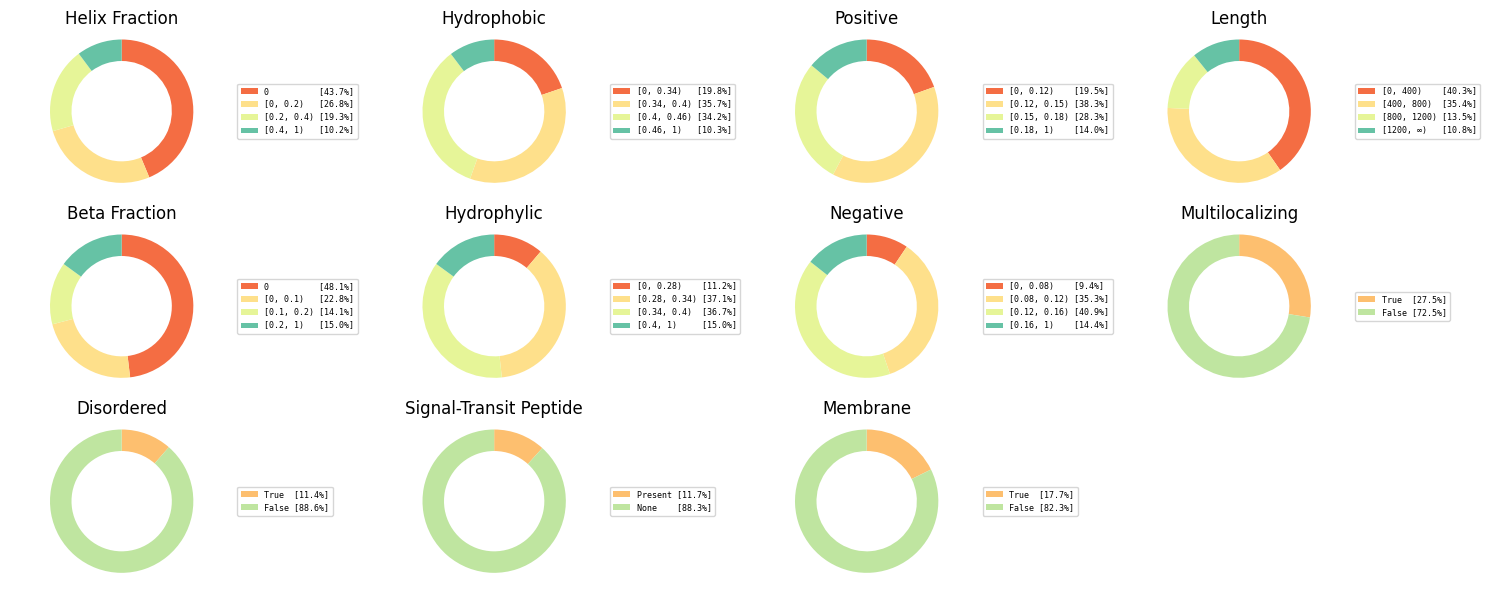

In [28]:
#VISUALZE BINS

ordered_categories2 = {
    'Helix_Fraction_Status': ["0", "[0, 0.2)", "[0.2, 0.4)", "[0.4, 1)"],
    'Hydrophobic_Status': ["[0, 0.34)", "[0.34, 0.4)", "[0.4, 0.46)", "[0.46, 1)"],
    'Positive_Status': ["[0, 0.12)", "[0.12, 0.15)", "[0.15, 0.18)", "[0.18, 1)"],
    'Length_Status': ['[0, 400)', '[400, 800)', '[800, 1200)', '[1200, ∞)'],
    'Beta_Fraction_Status': ["0", "[0, 0.1)", "[0.1, 0.2)", "[0.2, 1)"],
    'Hydrophylic_Status': ["[0, 0.28)", "[0.28, 0.34)", "[0.34, 0.4)", "[0.4, 1)"],
    'Negative_Status': ["[0, 0.08)", "[0.08, 0.12)", "[0.12, 0.16)", "[0.16, 1)"],
    'Multilocalizing_Status': [True, False],
    'Disordered_Status': [True, False],
    'Signal-Transit_Peptide_Status': ['Present', 'None'],
    'Membrane_Status': [True, False]
}


cols = ordered_categories2.keys()
titles = [" ".join(c.split("_")[:-1]) for c in cols]

fig, axs = plt.subplots(3, 4, figsize=(15, 6))
axs = axs.flatten()
for idx, col in enumerate(cols):
    make_circle_plot(hou, col, titles[idx], cmap='Spectral', ax=axs[idx], order=ordered_categories2[col])

axs[-1].axis('off')

plt.tight_layout()

plt.savefig(f"{FIG_DIR}/hou_binning_frequency.pdf", bbox_inches='tight', dpi=300)

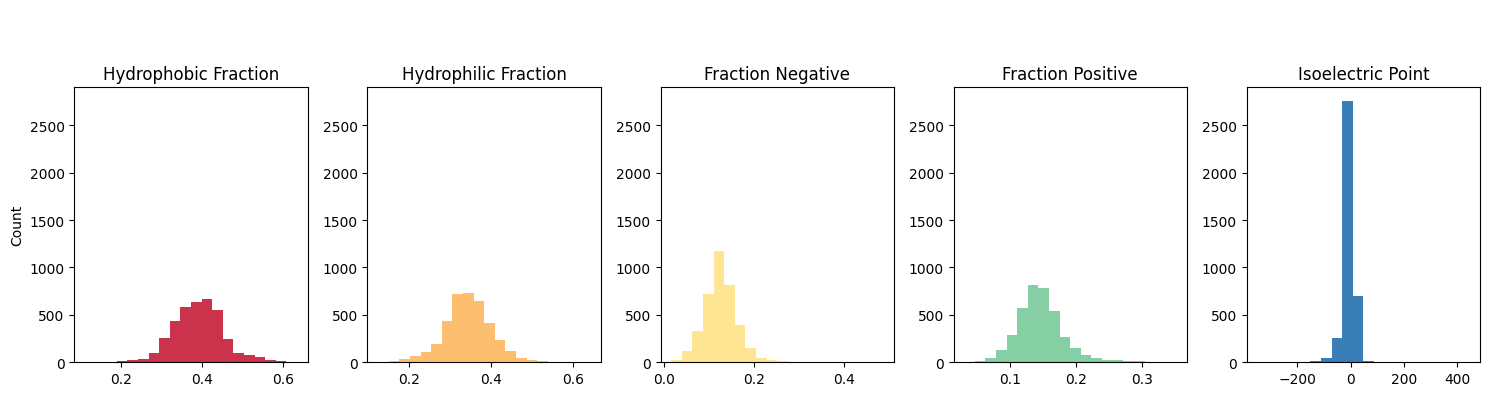

In [12]:
#VISUALIZE CHARGE + POLARITY HISTOGRAMS
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for ax in axs.ravel():
    ax.spines['top']
    ax.spines['bottom']
    ax.spines['left']
    ax.spines['right']
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

colors = sns.color_palette("Spectral", n_colors=11).as_hex()

axs[0].hist(hou['Fraction Hydrophobic'], bins=20, color=colors[0])
axs[0].set_ylabel("Count")
axs[0].set_title('Hydrophobic Fraction')
axs[1].hist(hou['Fraction Hydrophylic'], bins=20, color=colors[3])
axs[1].set_title('Hydrophilic Fraction')
axs[2].hist(hou['Fraction Negative'], bins=20, color=colors[4])
axs[2].set_title('Fraction Negative')
axs[3].hist(hou['Fraction Positive'], bins=20, color=colors[8])
axs[3].set_title('Fraction Positive')
axs[4].hist(hou['Isoelectric Point'], bins=20, color=colors[10])
axs[4].set_title('Isoelectric Point')

# Set the same ylim for all axes
for ax in axs:
    ax.set_ylim(0, 2900)


fig.suptitle('HOU Test Set - Sequence Features', color='white', fontsize=25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/hou_charge_polarity_hist.pdf", bbox_inches='tight', dpi=300)

Next we compute our performance metrics for proteins within each of the defined bins

In [ ]:
BINNED_METRICS = "../../datasets/intermediate/stratification/binned_metrics.csv"

if not os.exists(BINNED_METRICS):
    PATH_TO_BEST_MODEL = get_best_model_path()
    thresholds = np.load(f"{PATH_TO_BEST_MODEL}/all_thresholds.npy")
    preds_bin = []
    preds_all = []
    for i in range(5):
        path = f"{PATH_TO_BEST_MODEL}/fold_{i}/fold_{i}_test_predictions.csv"
        preds_df = pd.read_csv(path)
        cols = preds_df.columns
        true_cols = [c for c in cols if "true" in c]
        pred_cols = [c for c in cols if "pred" in c]
        if i == 0:
            locations = np.array([c.split("_")[0] for c in true_cols])
            targets = np.array(preds_df[true_cols].to_numpy())
        else:
            assert (targets == preds_df[true_cols].to_numpy()).all()
            assert (locations == np.array([c.split("_")[0] for c in true_cols])).all()
            assert (locations == np.array([c.split("_")[0] for c in pred_cols])).all()
        preds = preds_df[pred_cols].to_numpy()
        preds = torch.sigmoid(torch.from_numpy(preds)).numpy()
        preds_all.append(preds)
        preds_bin.append((preds > thresholds[i]).astype(np.int16))
    preds_all = np.array(preds_all).mean(axis=0)
    preds_bin = (np.stack(preds_bin).mean(axis=0) > 0.5).astype(np.int16)

    properties = list(ordered_categories.keys())
    for prop in properties:
        all_results = preds_df.merge(hou, left_on="id", right_on="uniprot_id")
        bins = all_results[prop].unique().tolist()
        for b in ordered_categories[prop]:
            idxs = hou[hou[prop] == b].index.to_numpy()
            b_preds_all = preds_all[idxs]
            b_preds_bin = preds_bin[idxs]
            b_targets = targets[idxs]
            b_metrics = get_all_metrics(b_targets, b_preds_all, b_preds_bin, locations)
            binned_metrics.append([prop, b] + list(b_metrics.values()))
    binned_metrics_df = pd.DataFrame(BINNED_METRICS, columns = ["property", "bin"] + list(b_metrics.keys()))

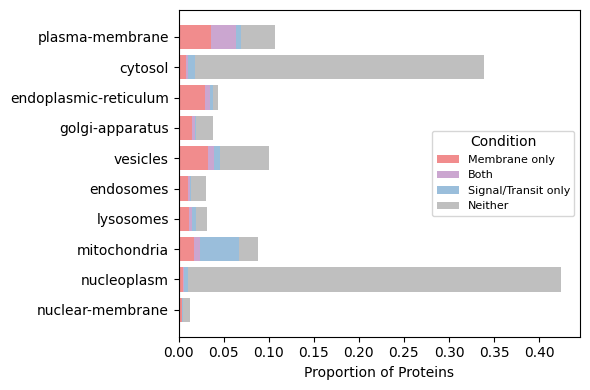

In [15]:
ordered_labels_level1 = [
                "cytoskeleton",
                "actin-filaments",
                "intermediate-filaments",
                "centrosome",
                "microtubules",
                "plasma-membrane",
                "cytosol",
                "endoplasmic-reticulum",
                "golgi-apparatus",
                "vesicles",
                "endosomes",
                "lysosomes",
                "peroxisomes",
                "lipid-droplets",
                "mitochondria",
                "nucleoplasm",
                "nuclear-bodies",
                "nuclear-membrane",
                "nuclear-speckles",
                "nucleoli",
                "nucleoli-fibrillar-center",
                ]

hou["locs"] = hou.level1.str.split(";")

hou["is_signal"] = hou["Signal-Transit_Peptide_Status"] == "Present"
hou["is_membrane"] = hou["Membrane_Status"] == True

compartment_counts = defaultdict(lambda: Counter())

for _, row in hou.iterrows():
    locs = row["locs"]
    is_sig = row["is_signal"]
    is_mem = row["is_membrane"]

    for loc in locs:
        if is_sig and is_mem:
            compartment_counts[loc]["Both"] += 1
        elif is_sig:
            compartment_counts[loc]["Signal/Transit only"] += 1
        elif is_mem:
            compartment_counts[loc]["Membrane only"] += 1
        else:
            compartment_counts[loc]["Neither"] += 1

plot_df = pd.DataFrame([
    {"location": loc, 
     "Membrane only": c["Membrane only"], 
     "Both": c["Both"],
     "Signal/Transit only": c["Signal/Transit only"], 
     "Neither": c["Neither"]
     }
    for loc, c in compartment_counts.items()
])

plot_df["location"] = pd.Categorical(plot_df["location"], ordered_labels_level1)
plot_df = plot_df.sort_values("location")

total = len(hou)
plot_df["Membrane only"] /= total
plot_df["Signal/Transit only"] /= total
plot_df["Both"] /= total
plot_df["Neither"] /= total

plot_df = plot_df[(plot_df["Membrane only"]> 0) |  (plot_df["Signal/Transit only"]> 0) | (plot_df["Both"]> 0)]
plot_df = plot_df.set_index("location")
#order = [loc for loc in ordered_labels_level1 if loc in plot_df.index]
order = [
    "plasma-membrane",
    "cytosol",
    "endoplasmic-reticulum",
    "golgi-apparatus",
    "vesicles",
    "endosomes",
    "lysosomes",
    "mitochondria",
    "nucleoplasm",
    "nuclear-membrane",
]
plot_df  = plot_df.loc[order[::-1]]
plot_df = plot_df.reset_index()

left_membrane = 0
left_both = plot_df["Membrane only"]
left_signal = left_both + plot_df["Both"]
left_neither = left_signal + plot_df["Signal/Transit only"]

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.barh(plot_df["location"], plot_df["Membrane only"], left=left_membrane,
        label="Membrane only", color="#e41a1c", alpha=0.5)  # Red
ax.barh(plot_df["location"], plot_df["Both"], left=left_both,
        label="Both", color="#984ea3", alpha=0.5)  # Purple
ax.barh(plot_df["location"], plot_df["Signal/Transit only"], left=left_signal,
        label="Signal/Transit only", color="#377eb8", alpha=0.5)  # Blue
ax.barh(plot_df["location"], plot_df["Neither"], left=left_neither,
        label="Neither", color="gray", alpha=0.5)

ax.set_xlabel("Proportion of Proteins")
ax.set_ylabel("")
ax.legend(title="Condition", fontsize=8)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/stratification_membrane_signal_class_freqs.pdf", bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_66275/2057752496.py:22: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
/tmp/ipykernel_66275/2057752496.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels, rotation=45)
/tmp/ipykernel_66275/2057752496.py:22: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
/tmp/ipykernel_66275/2057752496.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels, rotation=45)
/tmp/ipykernel_66275/2057752496.py:22: UserWarning: The palette list has more values (5) than needed (4), which may not be

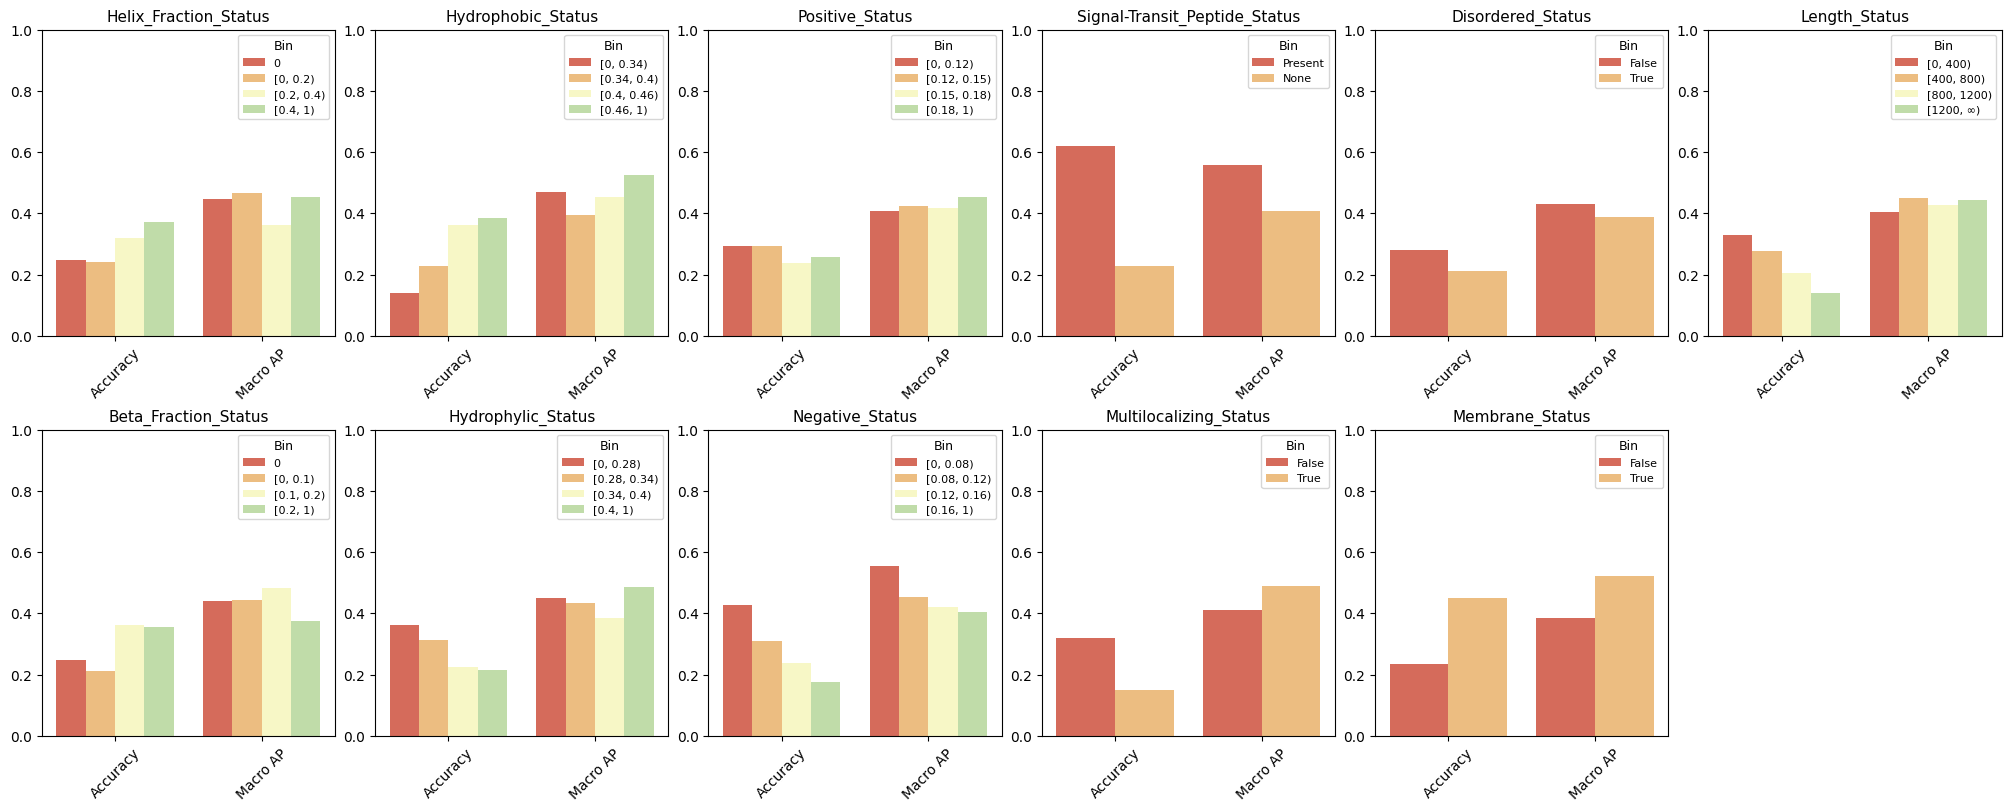

In [17]:
avg_metrics = ['acc_samples', 'macro_ap', ]
palette = sns.color_palette("Spectral", n_colors=5)


fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 8), constrained_layout=True)
axes = axes.flatten()

properties = list(ordered_categories.keys())
custom_labels = ['Accuracy', 'Macro AP']

for idx, prop in enumerate(properties):
    ax = axes[idx]
    subset = binned_metrics_df[binned_metrics_df['property'] == prop]

    subset_long = subset.melt(
        id_vars=['bin'],
        value_vars=avg_metrics,
        var_name='metric',
        value_name='value'
    )

    sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
    

    ax.set_title(prop, fontsize=11)
    ax.set_xlabel('')
    ax.set_xticklabels(custom_labels, rotation=45)
    ax.set_ylabel('')
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Bin', fontsize=8, title_fontsize=9, loc='upper right')

for j in range(len(properties), len(axes)):
    fig.delaxes(axes[j])

plt.savefig(f"{FIG_DIR}/stratification_acc_macroap.pdf", bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_66275/87768087.py:21: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
/tmp/ipykernel_66275/87768087.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels, rotation=45)
/tmp/ipykernel_66275/87768087.py:21: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
/tmp/ipykernel_66275/87768087.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels, rotation=45)
/tmp/ipykernel_66275/87768087.py:21: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.

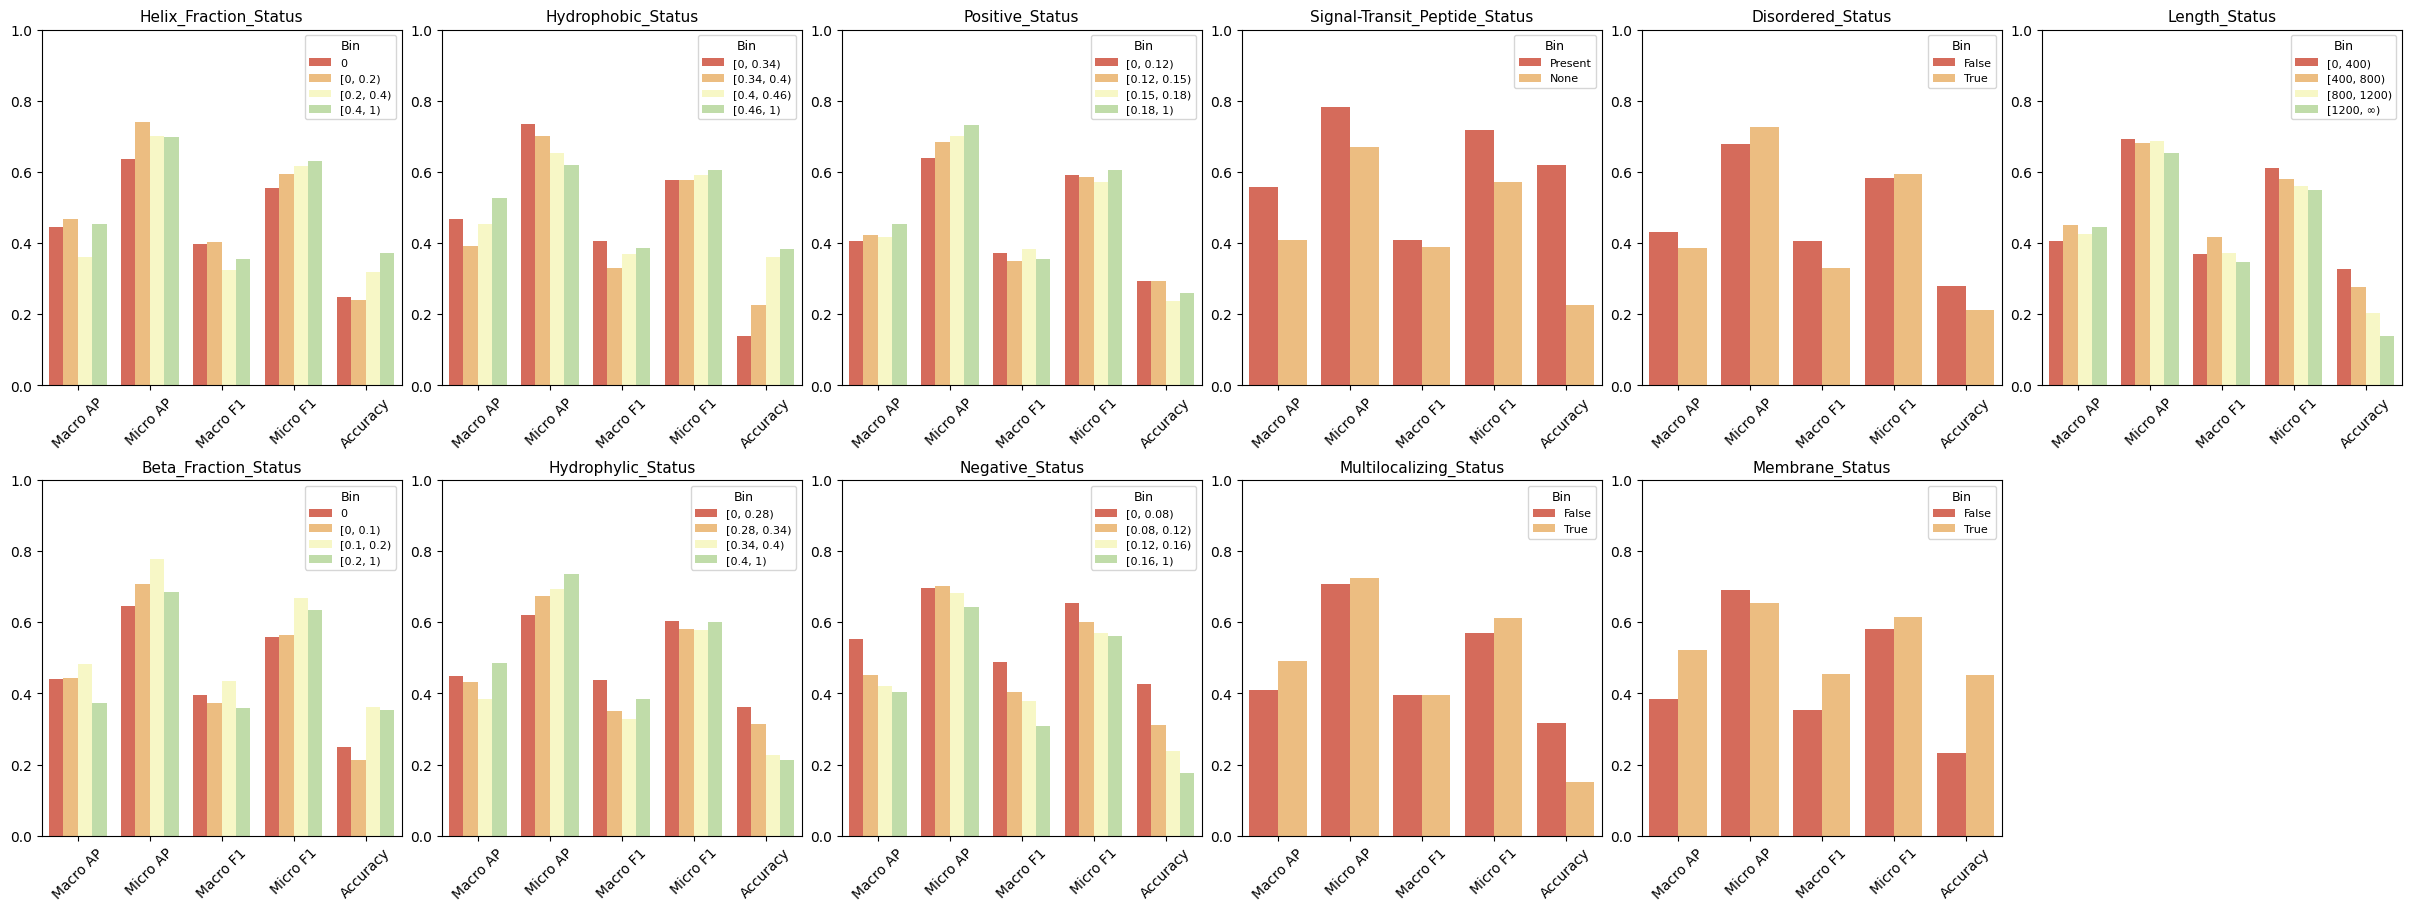

In [18]:
avg_metrics = ['macro_ap', 'micro_ap', 'f1_macro', 'f1_micro', 'acc_samples']
palette = sns.color_palette("Spectral", n_colors=5)

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 9), constrained_layout=True)
axes = axes.flatten()

properties = list(ordered_categories.keys())
custom_labels = ['Macro AP', 'Micro AP', 'Macro F1', 'Micro F1', 'Accuracy']

for idx, prop in enumerate(properties):
    ax = axes[idx]
    subset = binned_metrics_df[binned_metrics_df['property'] == prop]

    subset_long = subset.melt(
        id_vars=['bin'],
        value_vars=avg_metrics,
        var_name='metric',
        value_name='value'
    )

    sns.barplot(data=subset_long, x='metric', y='value', hue='bin', palette=palette, ax=ax)
    

    ax.set_title(prop, fontsize=11)
    ax.set_xlabel('')
    ax.set_xticklabels(custom_labels, rotation=45)
    ax.set_ylabel('')
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Bin', fontsize=8, title_fontsize=9, loc='upper right')

for j in range(len(properties), len(axes)):
    fig.delaxes(axes[j])

plt.savefig(f"{FIG_DIR}/stratification_avg_metrics.pdf", bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_66275/2089404291.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


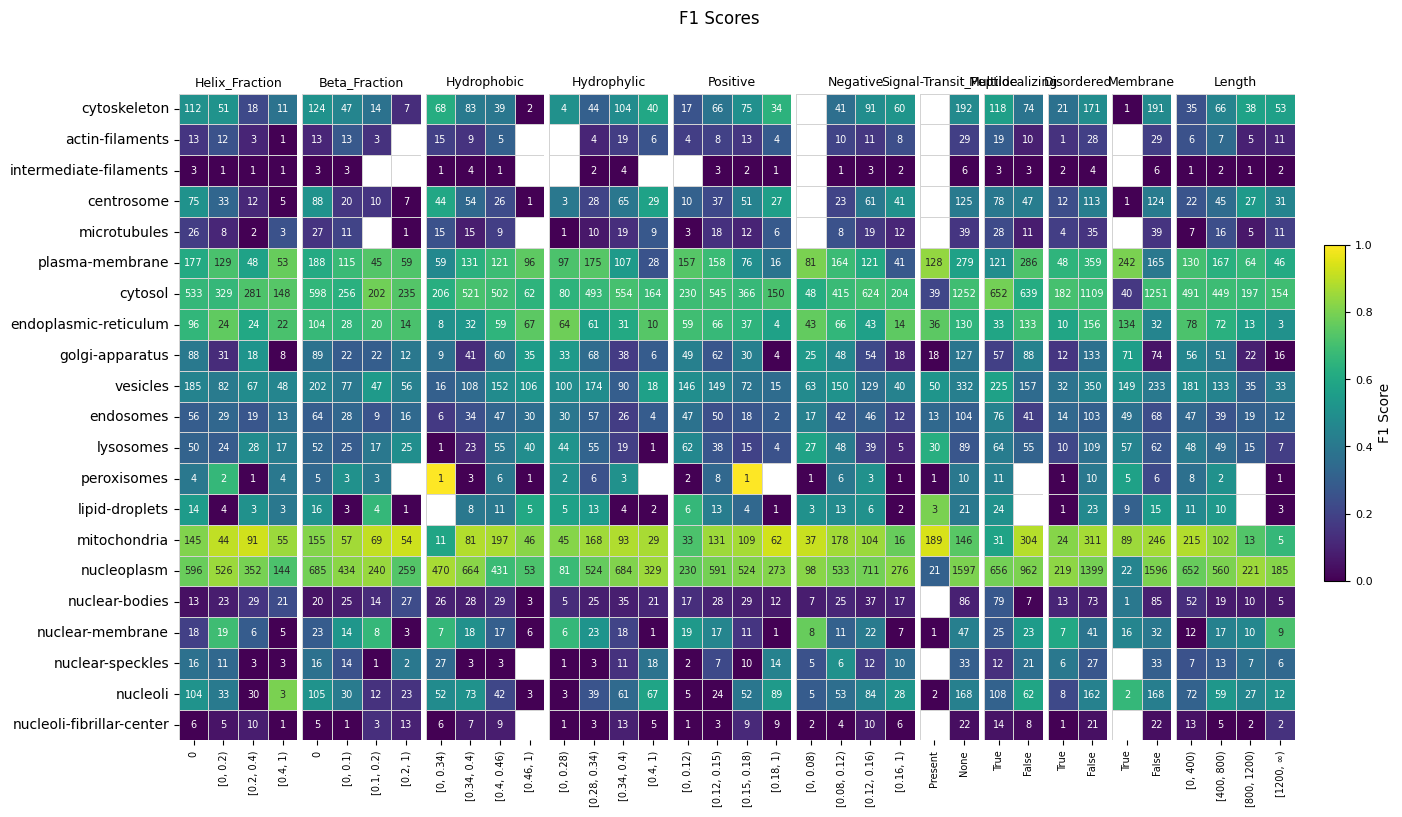

In [19]:
properties = [
    'Helix_Fraction_Status',
    'Beta_Fraction_Status',
    'Hydrophobic_Status',
    'Hydrophylic_Status',
    'Positive_Status',
    'Negative_Status',
    'Signal-Transit_Peptide_Status',
    'Multilocalizing_Status',
    'Disordered_Status',
    'Membrane_Status',
    'Length_Status'
    ]

class_order = [
            "cytoskeleton",
            "actin-filaments",
            "intermediate-filaments",
            "centrosome",
            "microtubules",
            "plasma-membrane",
            "cytosol",
            "endoplasmic-reticulum",
            "golgi-apparatus",
            "vesicles",
            "endosomes",
            "lysosomes",
            "peroxisomes",
            "lipid-droplets",
            "mitochondria",
            "nucleoplasm",
            "nuclear-bodies",
            "nuclear-membrane",
            "nuclear-speckles",
            "nucleoli",
            "nucleoli-fibrillar-center"
        ]
    

perclass_metrics = ['f1_perclass', "count_perclass"]
dfs_by_property = {}
count_dfs_by_property = {}
bin_counts = []

for prop in properties:
    prop_df = binned_metrics_df[binned_metrics_df.property == prop]
    bin_order = ordered_categories[prop]

    bin_labels = []
    prop_matrix = []
    count_matrix = []

    for b in bin_order:
        row = prop_df[prop_df.bin == b]
        if row.empty:
            continue
        values = row['f1_perclass'].values[0]
        locs = row['category_perclass'].values[0]
        loc_counts = row["count_perclass"].values[0]

        metric_vals = [values[locs.index(loc)] if loc in locs else np.nan for loc in class_order]
        count_vals = [loc_counts[locs.index(loc)] if loc in locs else np.nan for loc in class_order]
        prop_matrix.append(metric_vals)
        count_matrix.append(count_vals)
        bin_labels.append(b)

    prop_df_matrix = pd.DataFrame(np.array(prop_matrix).T, index=class_order, columns=bin_labels)
    count_df_matrix = pd.DataFrame(np.array(count_matrix).T, index=class_order, columns=bin_labels)
    dfs_by_property[prop] = prop_df_matrix
    count_dfs_by_property[prop] = count_df_matrix
    bin_counts.append(len(bin_labels))

width_ratios = bin_counts

cell_width = 0.4
cell_height = 0.4
fig_width = sum(width_ratios) * cell_width
fig_height = len(class_order) * cell_height

fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(1, len(properties), width_ratios=width_ratios, wspace=0.05)

vmin, vmax = 0, 1

axes = []
for i, prop in enumerate(properties):
    ax = fig.add_subplot(gs[0, i])
    df = dfs_by_property[prop]
    count_df = count_dfs_by_property[prop]
    sns.heatmap(df, ax=ax, cmap="viridis", cbar=False,
                linewidths=0.5, linecolor='lightgray', vmin=vmin, vmax=vmax,
                annot=count_df, fmt='.0f', annot_kws={"size": 7},  # count annotations
                )

    ax.set_title(prop.split("_Status")[0], fontsize=9)
    ax.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax.set_xticklabels(df.columns, rotation=90, fontsize=7)


    if i !=0:
        ax.set_ylabel("")
        ax.tick_params(left=False, labelleft=False)
        ax.set_yticklabels([])

    axes.append(ax)

cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('F1 Score', fontsize=10)
cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=8)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.suptitle("F1 Scores")
plt.savefig(f"{FIG_DIR}/stratification_f1_heatmap_annotated.pdf", bbox_inches='tight', dpi=300)
plt.show()

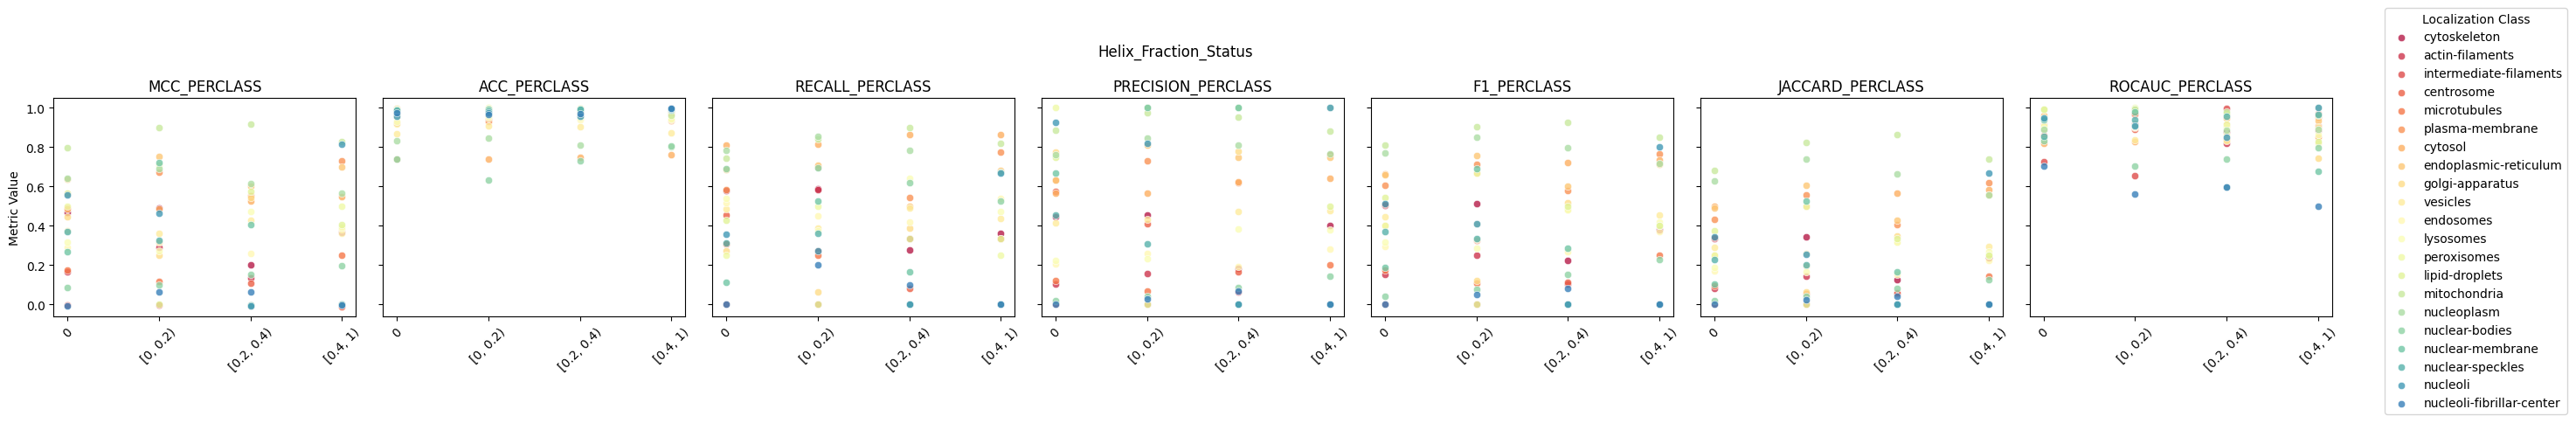

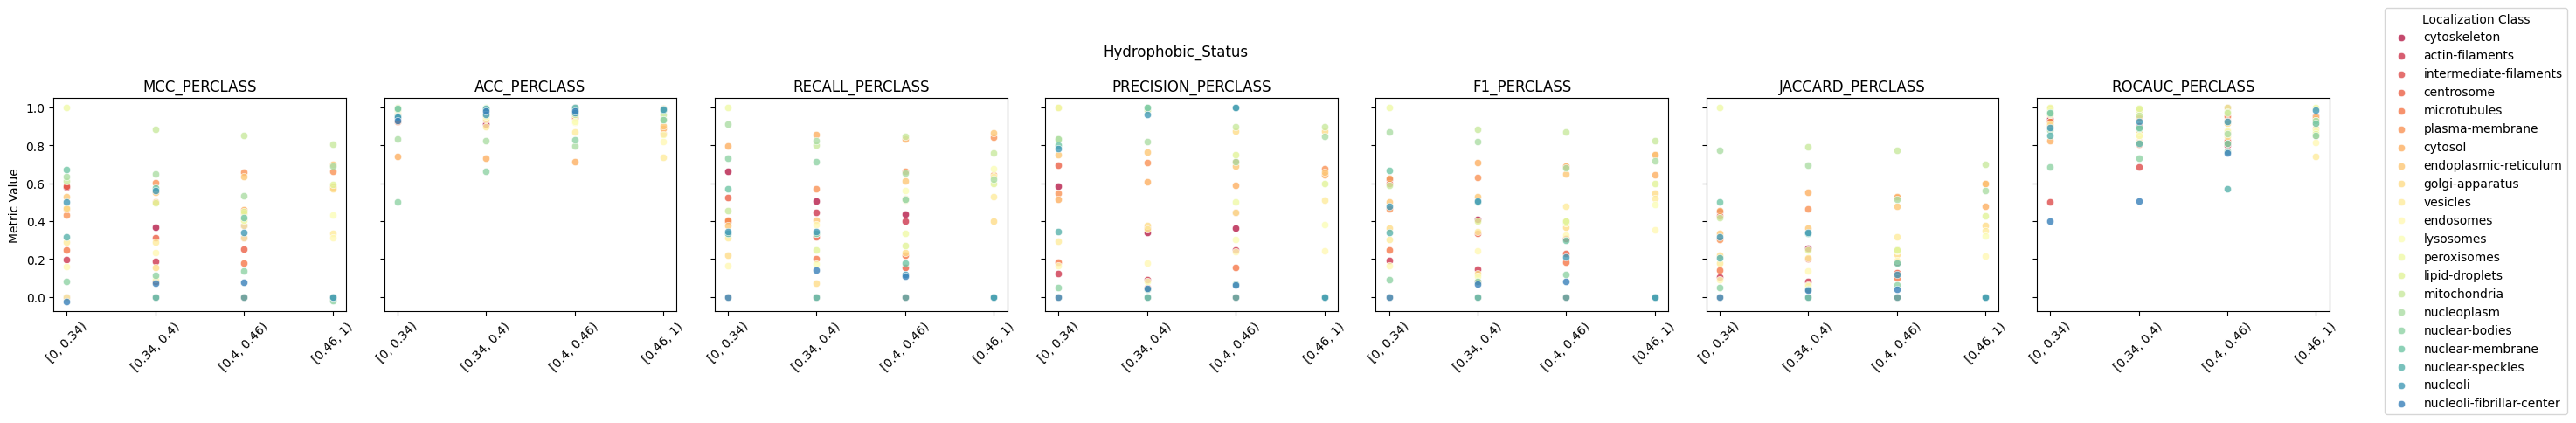

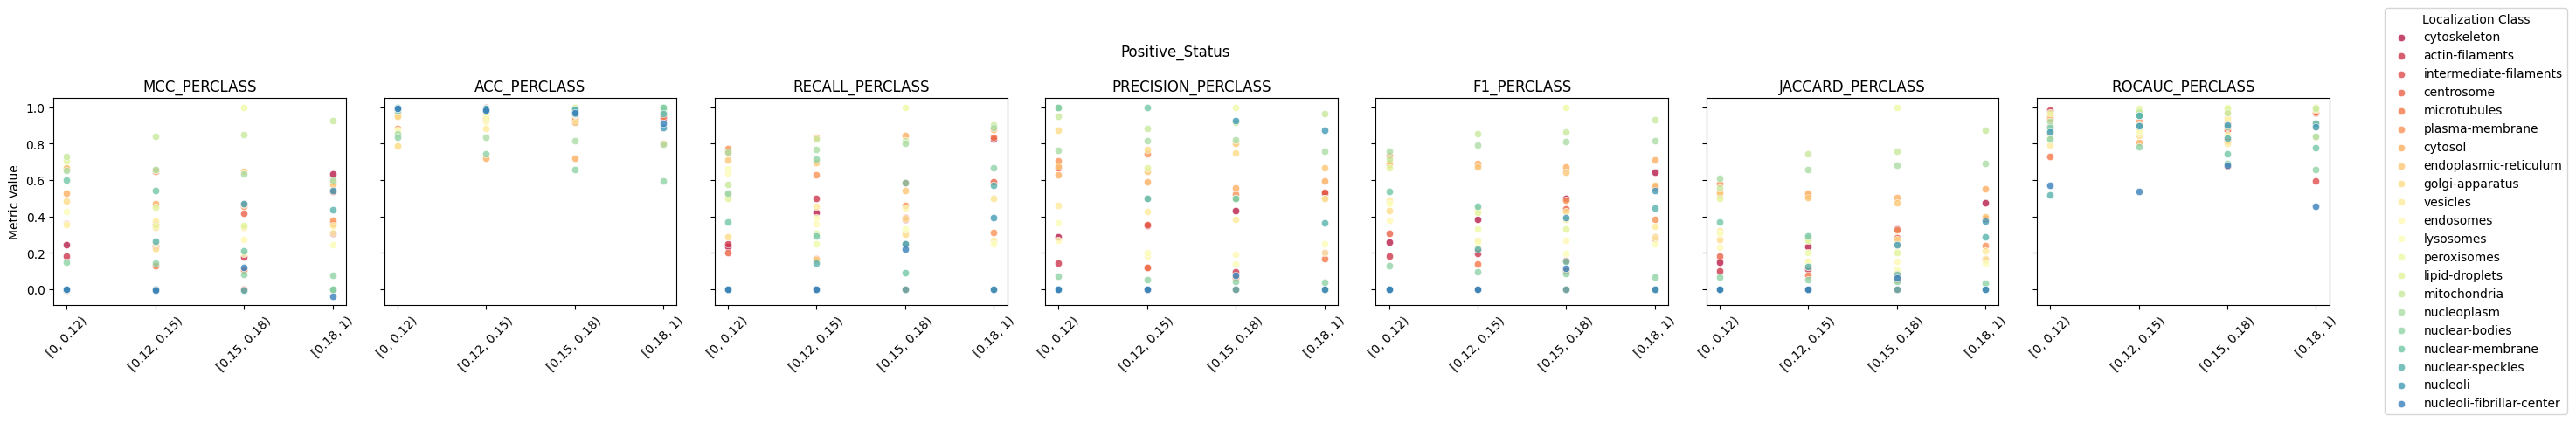

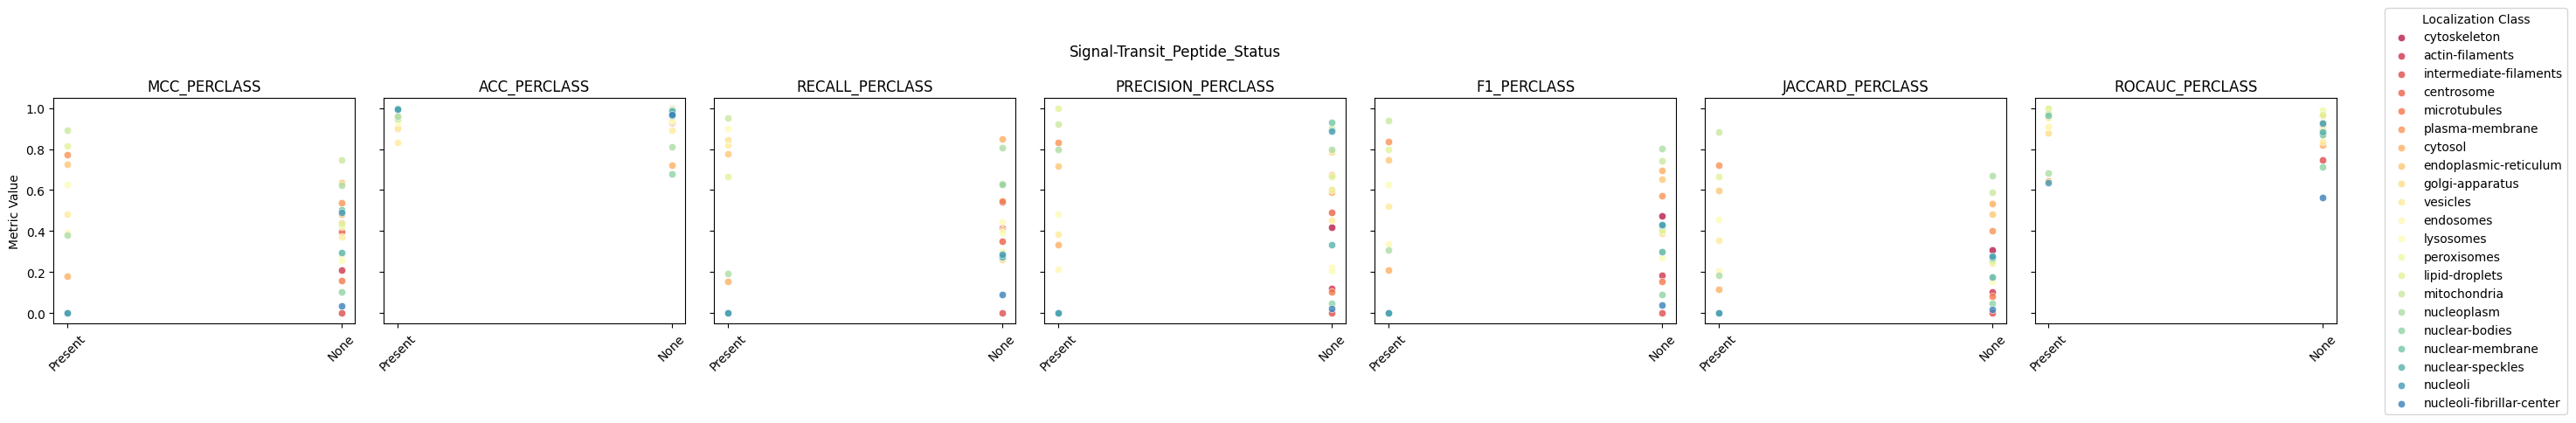

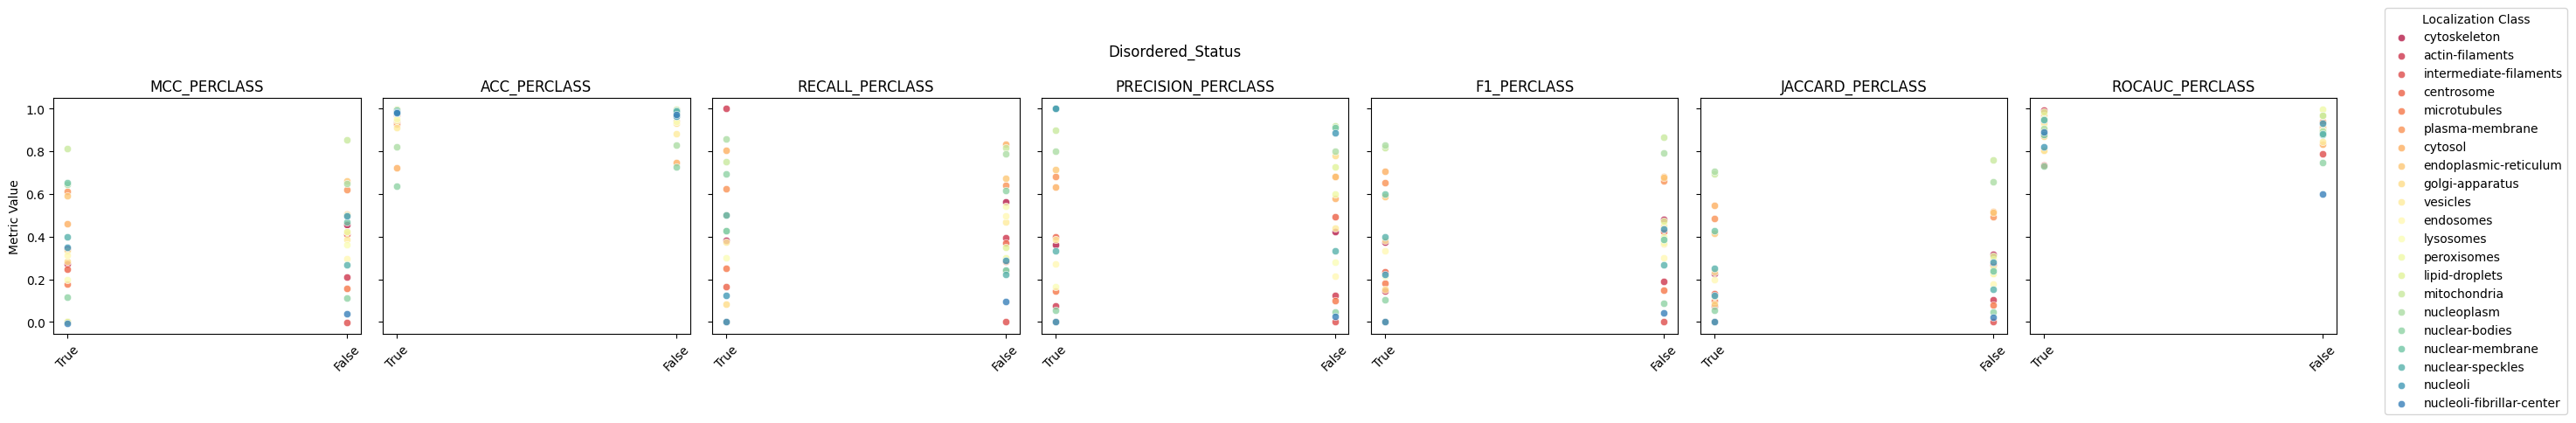

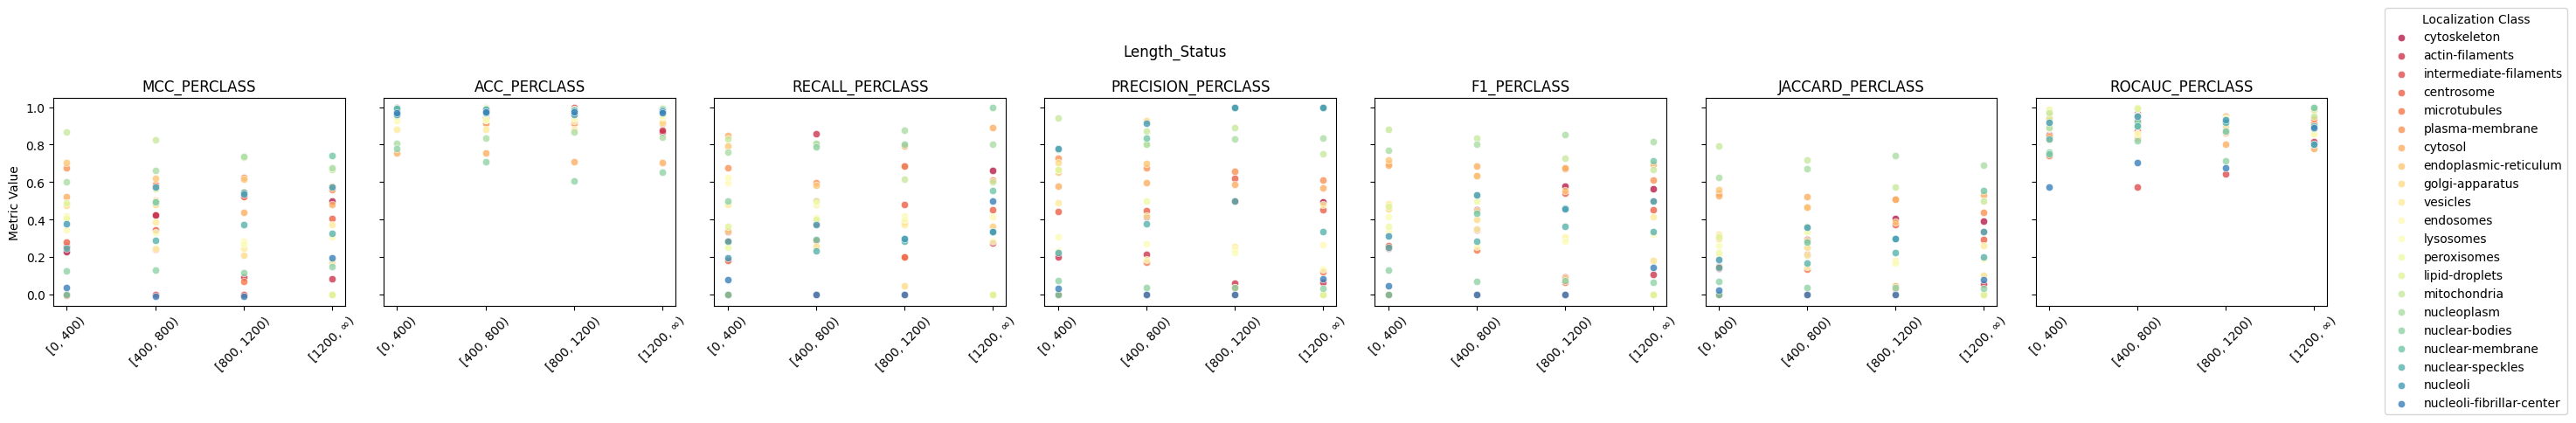

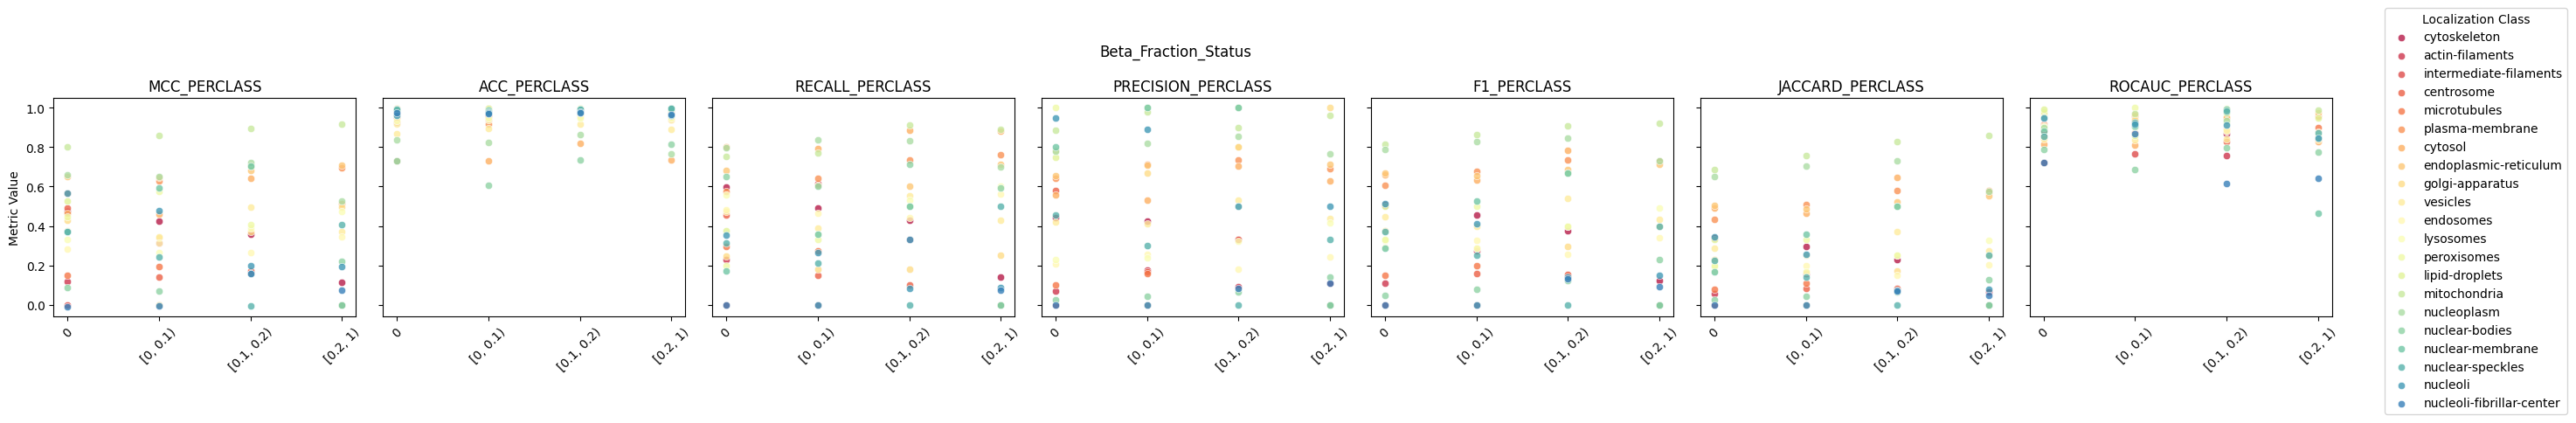

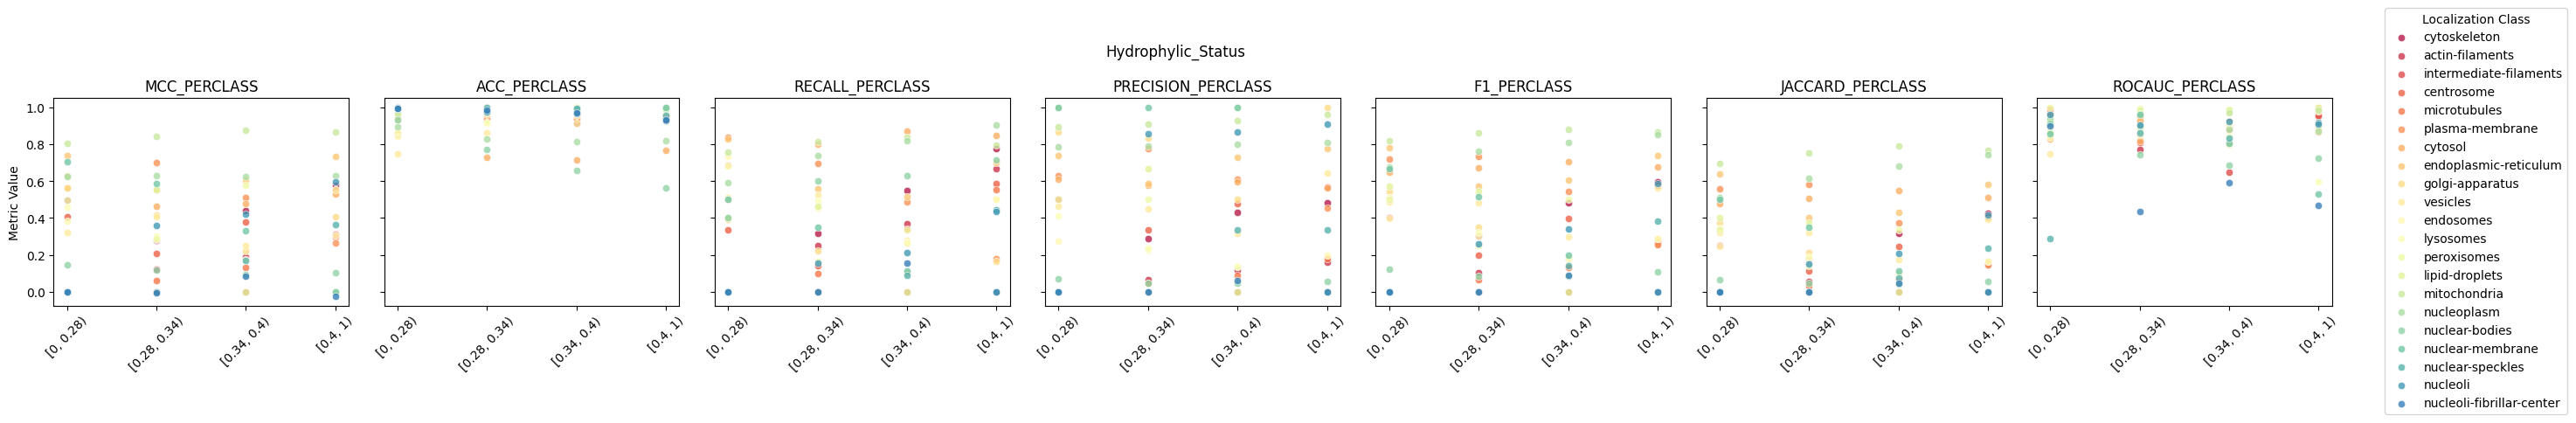

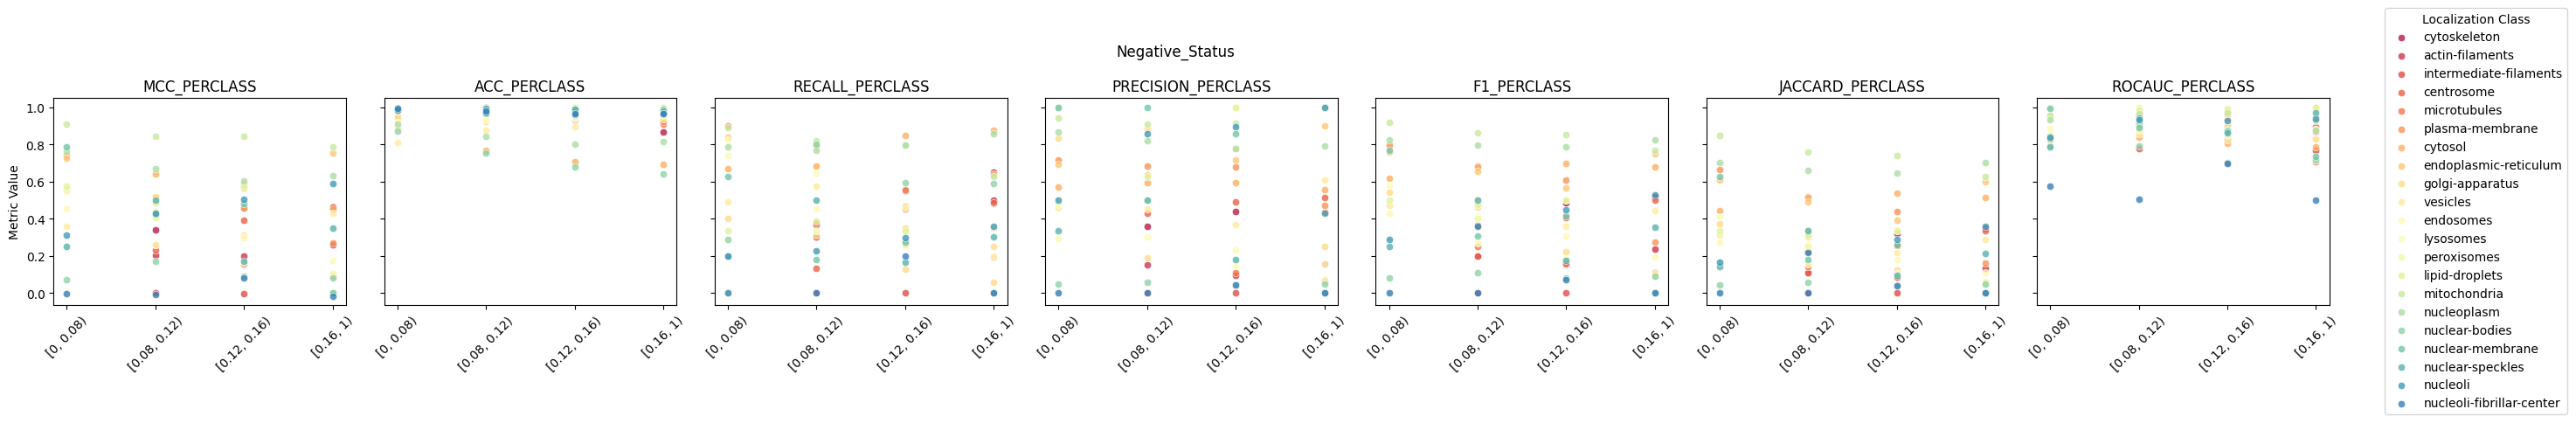

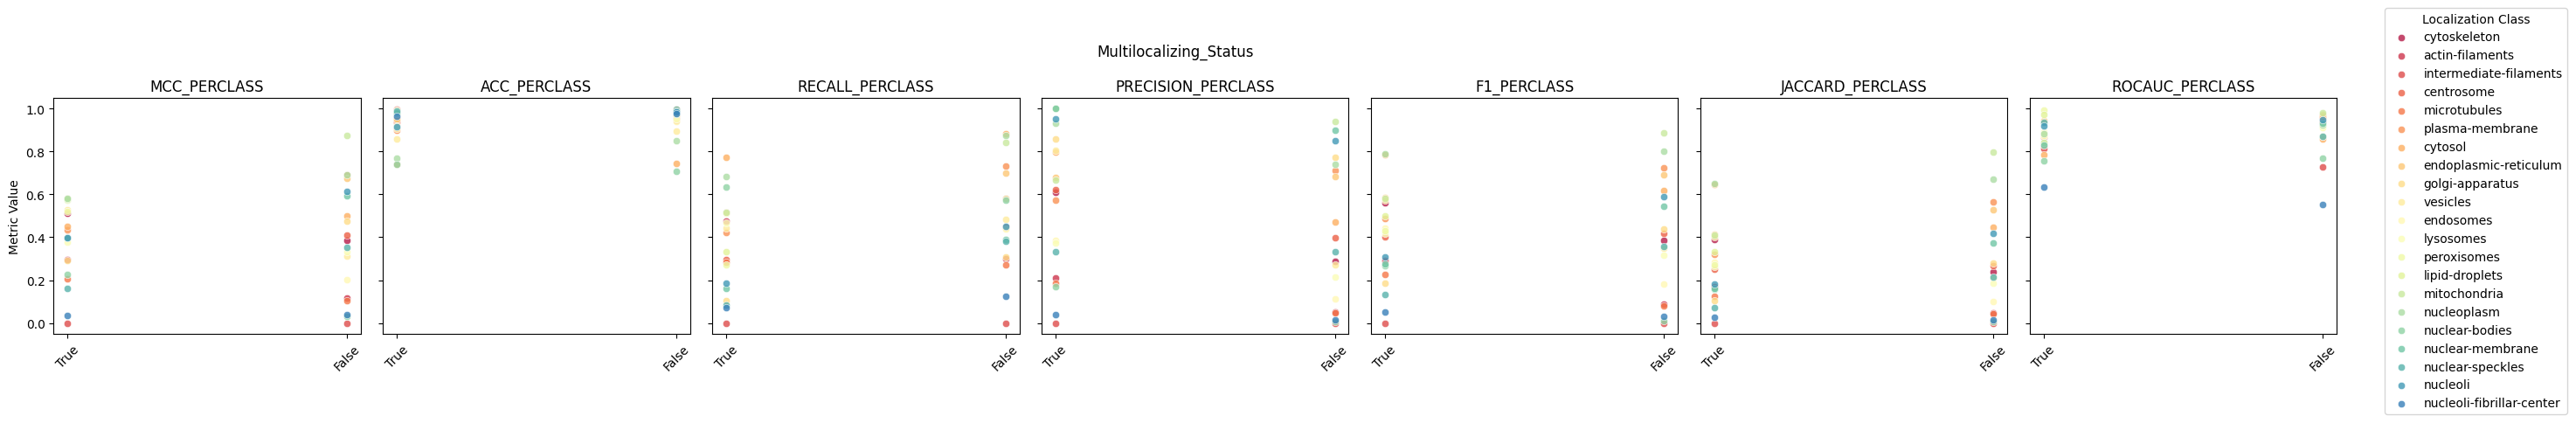

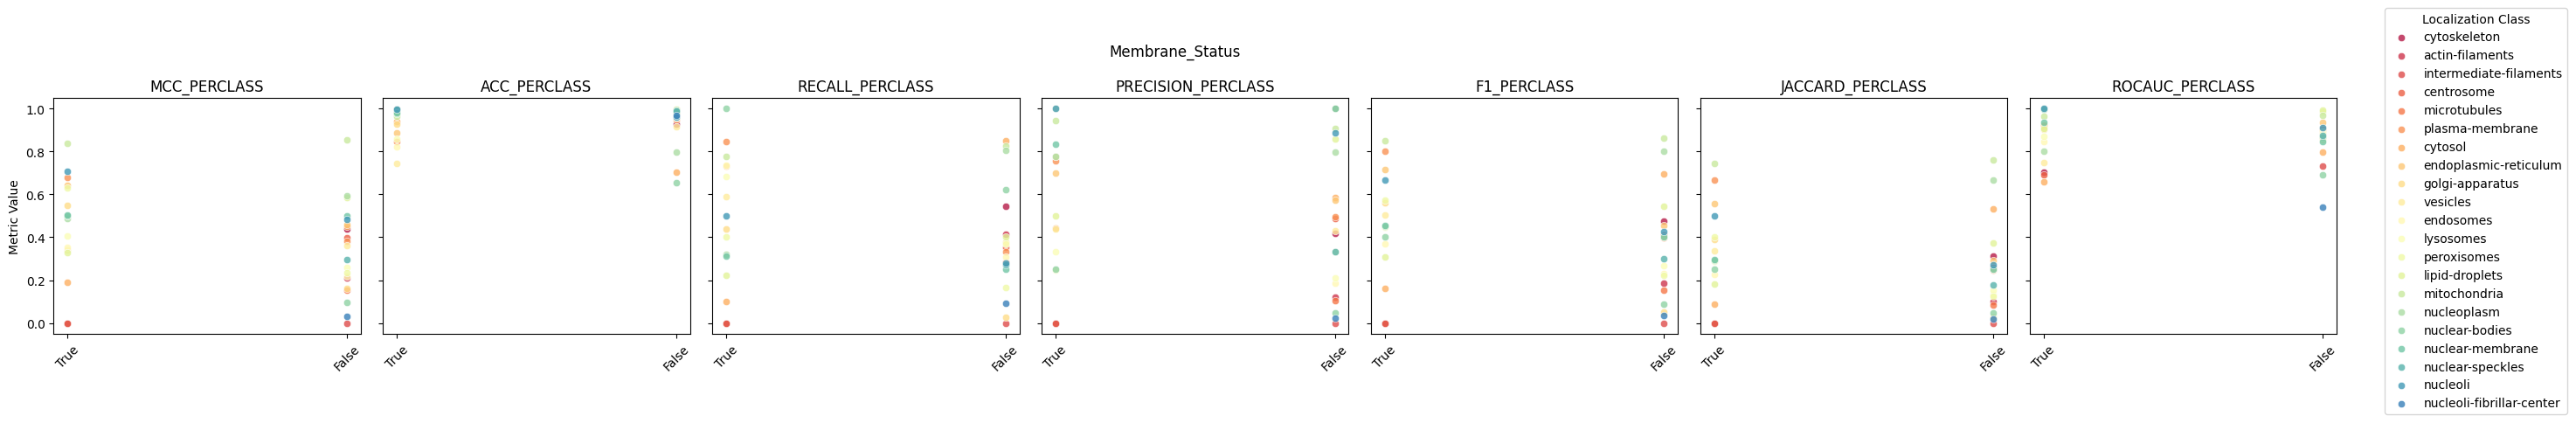

In [20]:
perclass_metrics = ['mcc_perclass', 'acc_perclass', 'recall_perclass', 'precision_perclass', 'f1_perclass', 'jaccard_perclass', 'rocauc_perclass']

for prop in binned_metrics_df['property'].unique():
    prop_df = binned_metrics_df[binned_metrics_df['property'] == prop]
    fig, axes = plt.subplots(1, len(perclass_metrics), figsize=(27, 4), sharex=False, sharey=True)

    class_order = [
                    "cytoskeleton",
                    "actin-filaments",
                    "intermediate-filaments",
                    "centrosome",
                    "microtubules",
                    "plasma-membrane",
                    "cytosol",
                    "endoplasmic-reticulum",
                    "golgi-apparatus",
                    "vesicles",
                    "endosomes",
                    "lysosomes",
                    "peroxisomes",
                    "lipid-droplets",
                    "mitochondria",
                    "nucleoplasm",
                    "nuclear-bodies",
                    "nuclear-membrane",
                    "nuclear-speckles",
                    "nucleoli",
                    "nucleoli-fibrillar-center"
                ]
    
    colors = sns.color_palette("Spectral", n_colors=22)
    class_color_map = dict(zip(class_order, colors))

    bin_order = ordered_categories[prop]

    handles = {}

    for j, metric in enumerate(perclass_metrics):
        for loc_class in class_order:
            xs = []
            ys = []

            for i, bin_label in enumerate(bin_order):
                bin_df = prop_df[prop_df['bin'] == bin_label]
                classes = bin_df.category_perclass.to_list()[0]
                
                if loc_class in classes:
                    idx = classes.index(loc_class)
                    y_val = bin_df[metric].values[0][idx]
                    xs.append(i)
                    ys.append(y_val)

            label = loc_class if loc_class not in handles else None
            plot = sns.scatterplot(
                x=xs,
                y=ys,
                color=class_color_map[loc_class],
                label=label,
                alpha=0.8,
                ax=axes[j]
            )
            if label:
                handles[loc_class] = plot.collections[-1]

        axes[j].set_xticks(range(len(bin_order)))
        axes[j].set_xticklabels(bin_order, rotation=45)
        axes[j].set_title(metric.upper())
        if j == 0:
            axes[j].set_ylabel("Metric Value")

    for ax in axes:
        if ax.get_legend():
            ax.legend_.remove()

    plt.suptitle(f'{prop}')
    fig.legend(
        handles=[handles[cls] for cls in class_order],
        labels=[cls for cls in class_order],
        title="Localization Class",
        loc='center left',
        bbox_to_anchor=(1.01, 0.5)
    )  
    plt.tight_layout()
    #plt.savefig(f"{FIG_DIR}/stratification_scatter_{prop}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

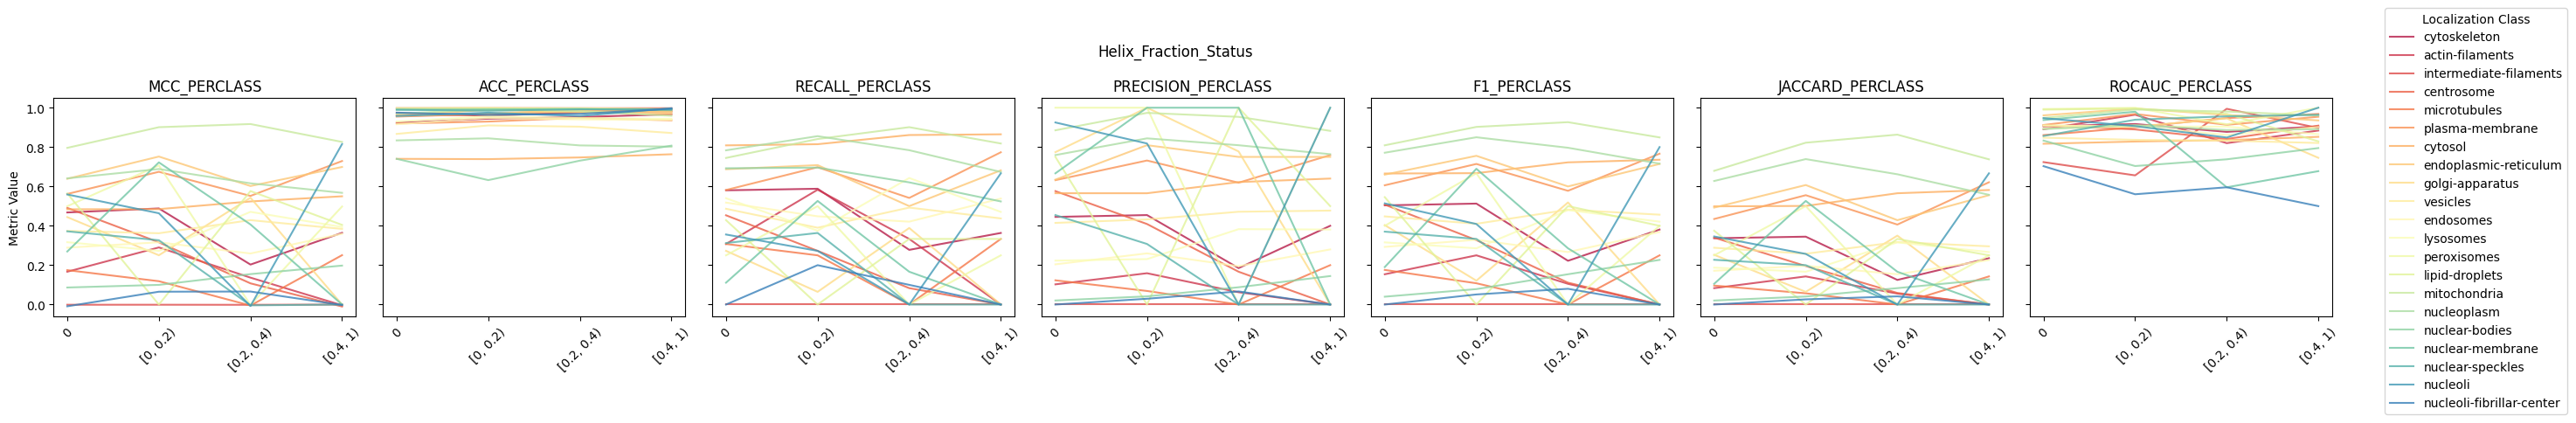

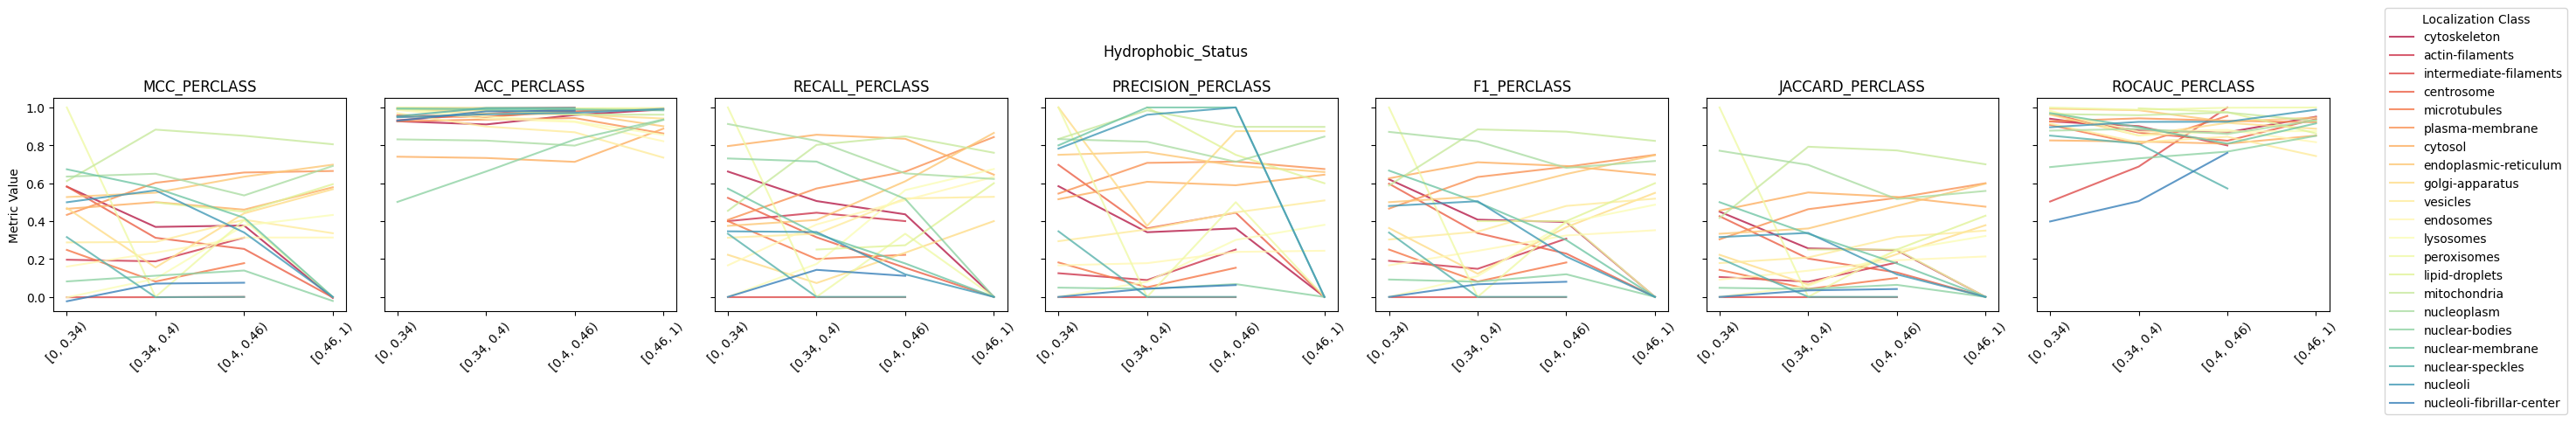

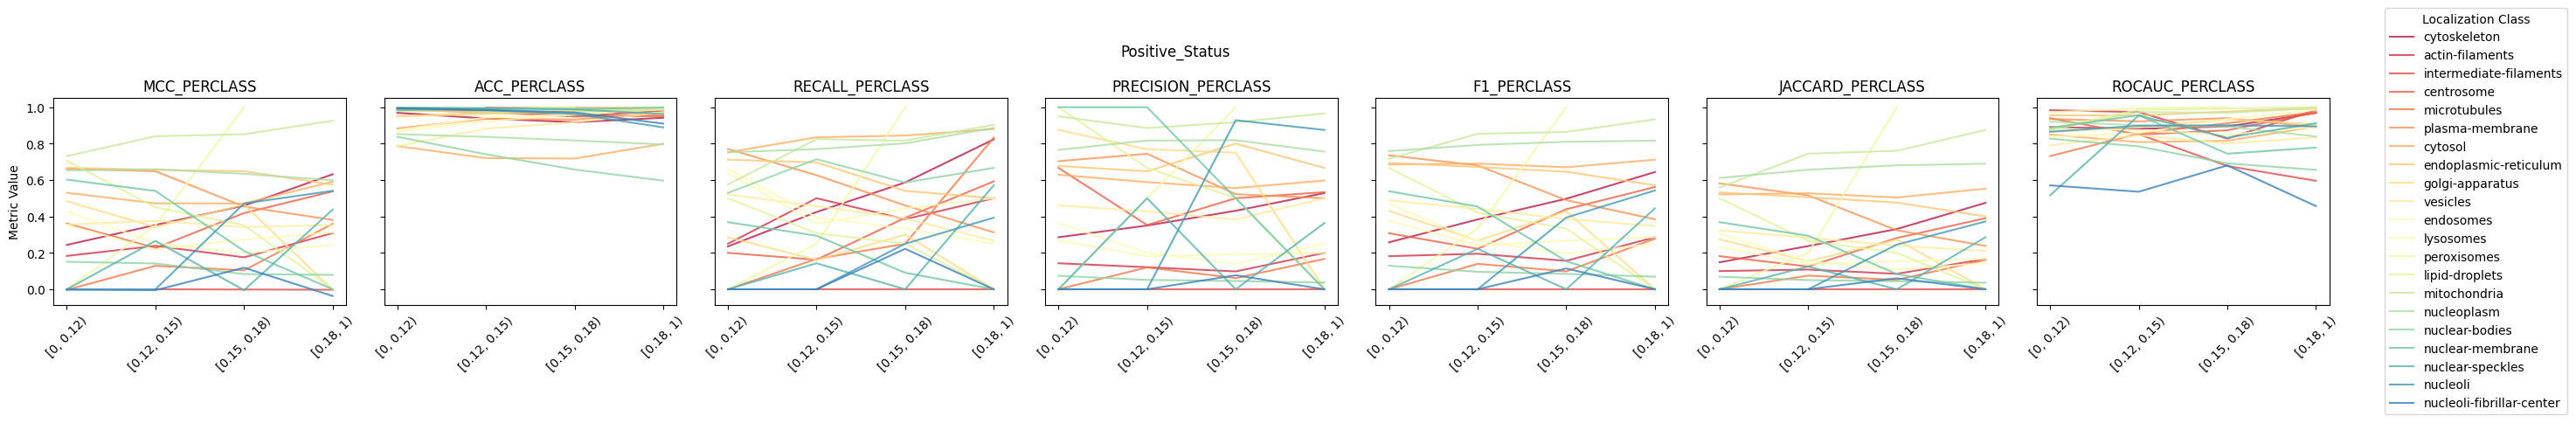

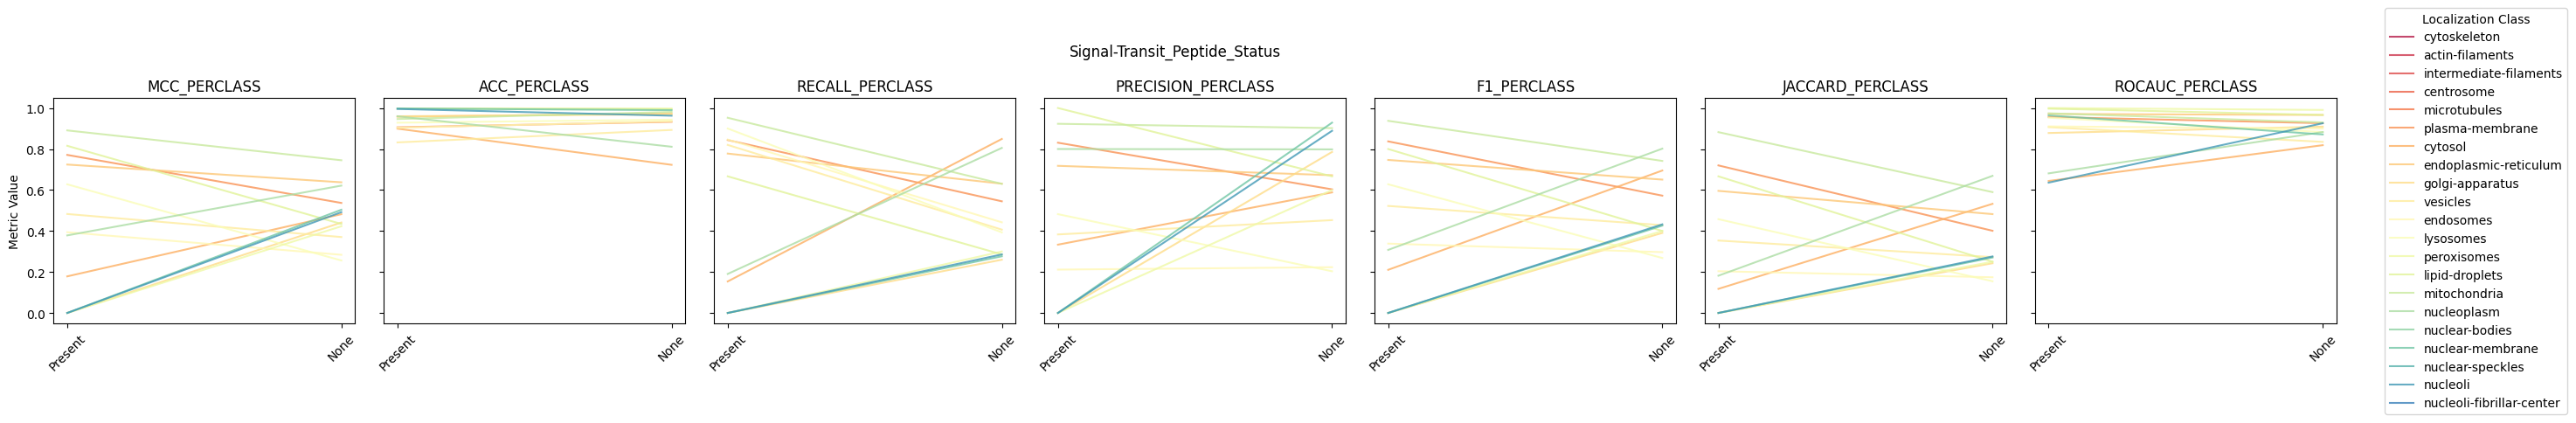

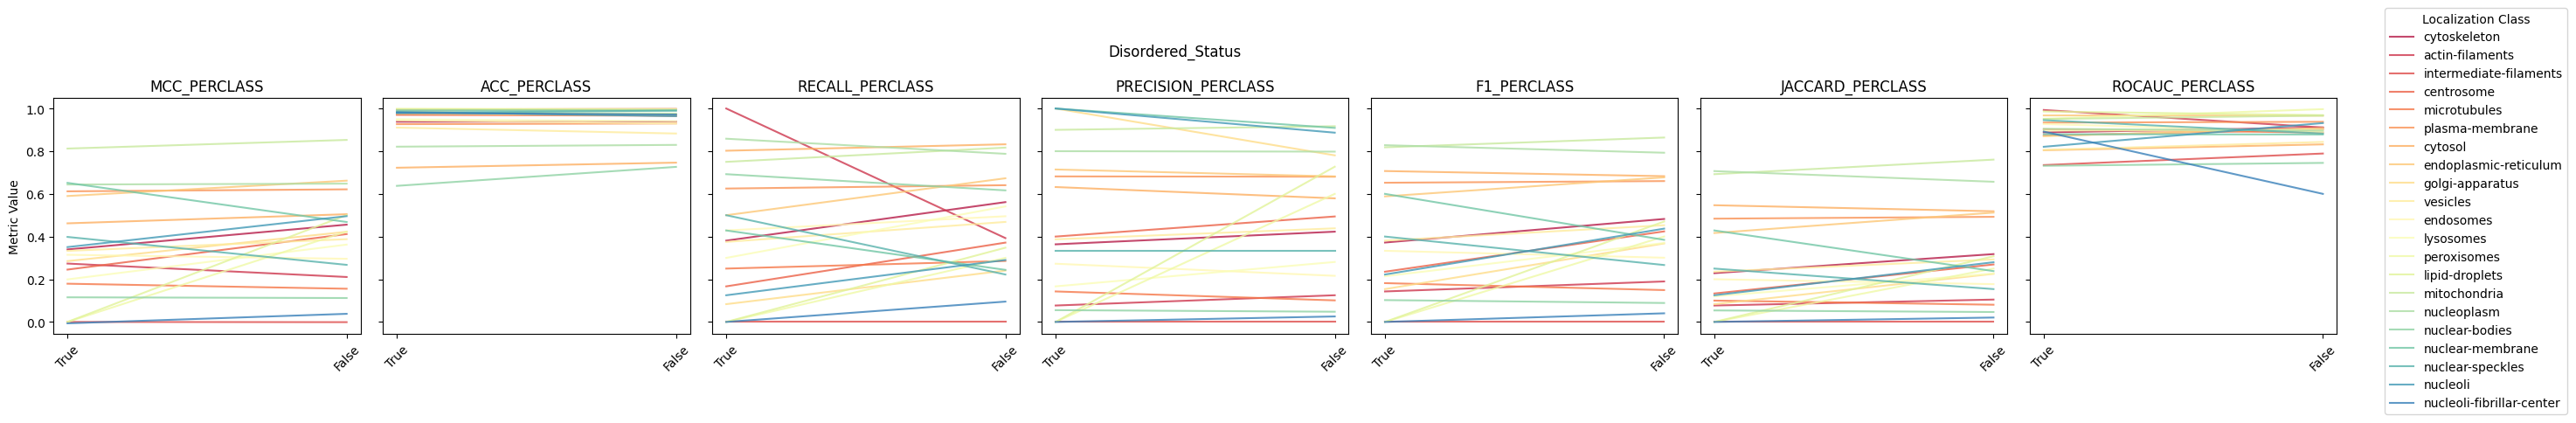

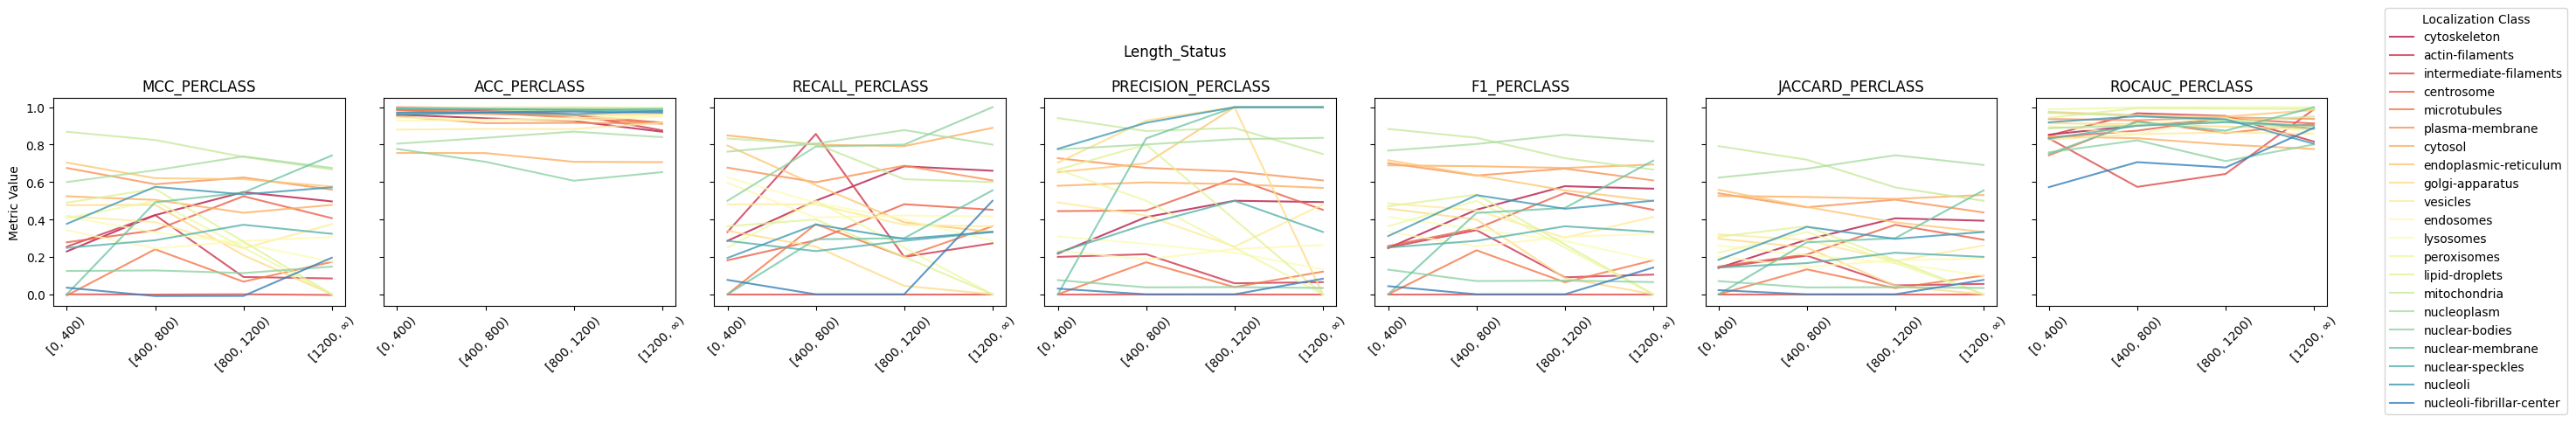

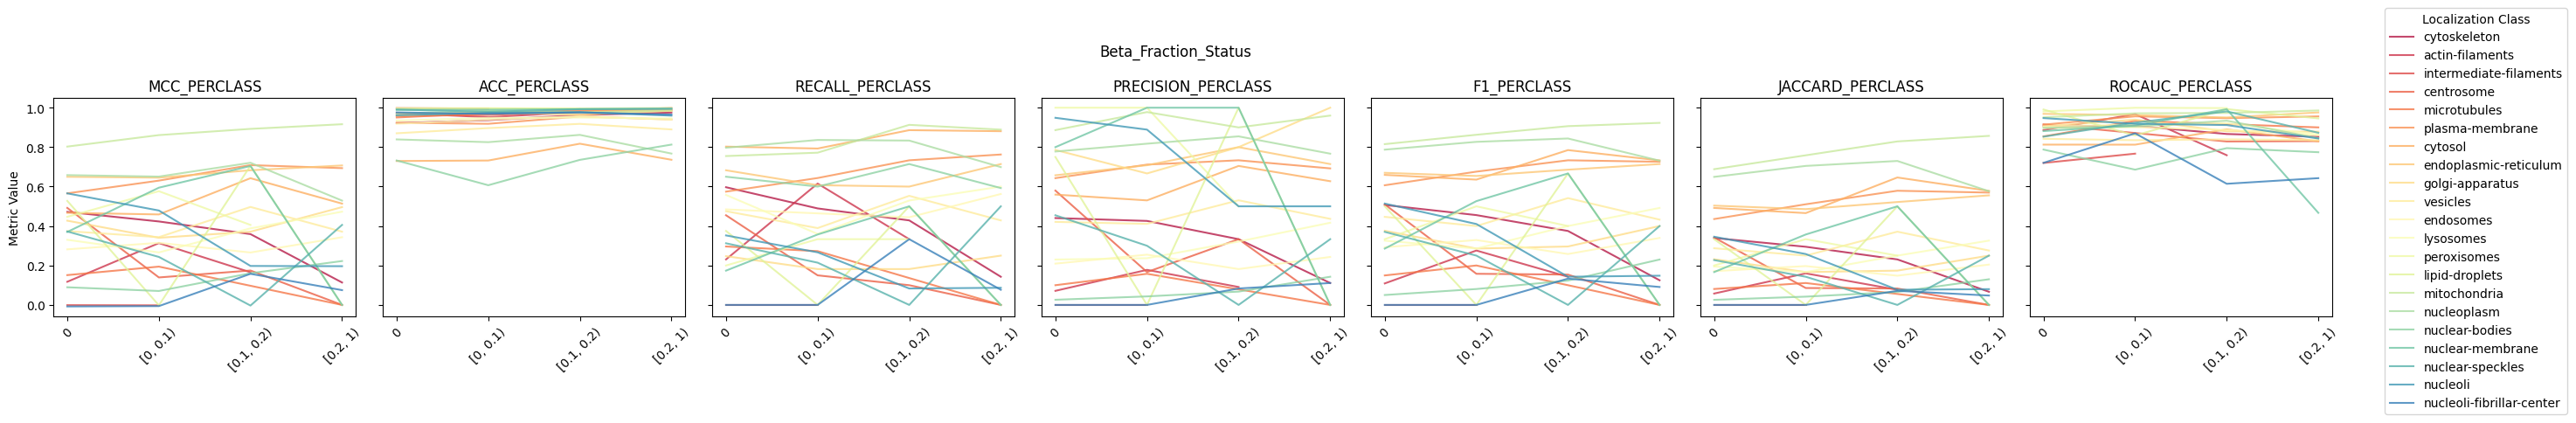

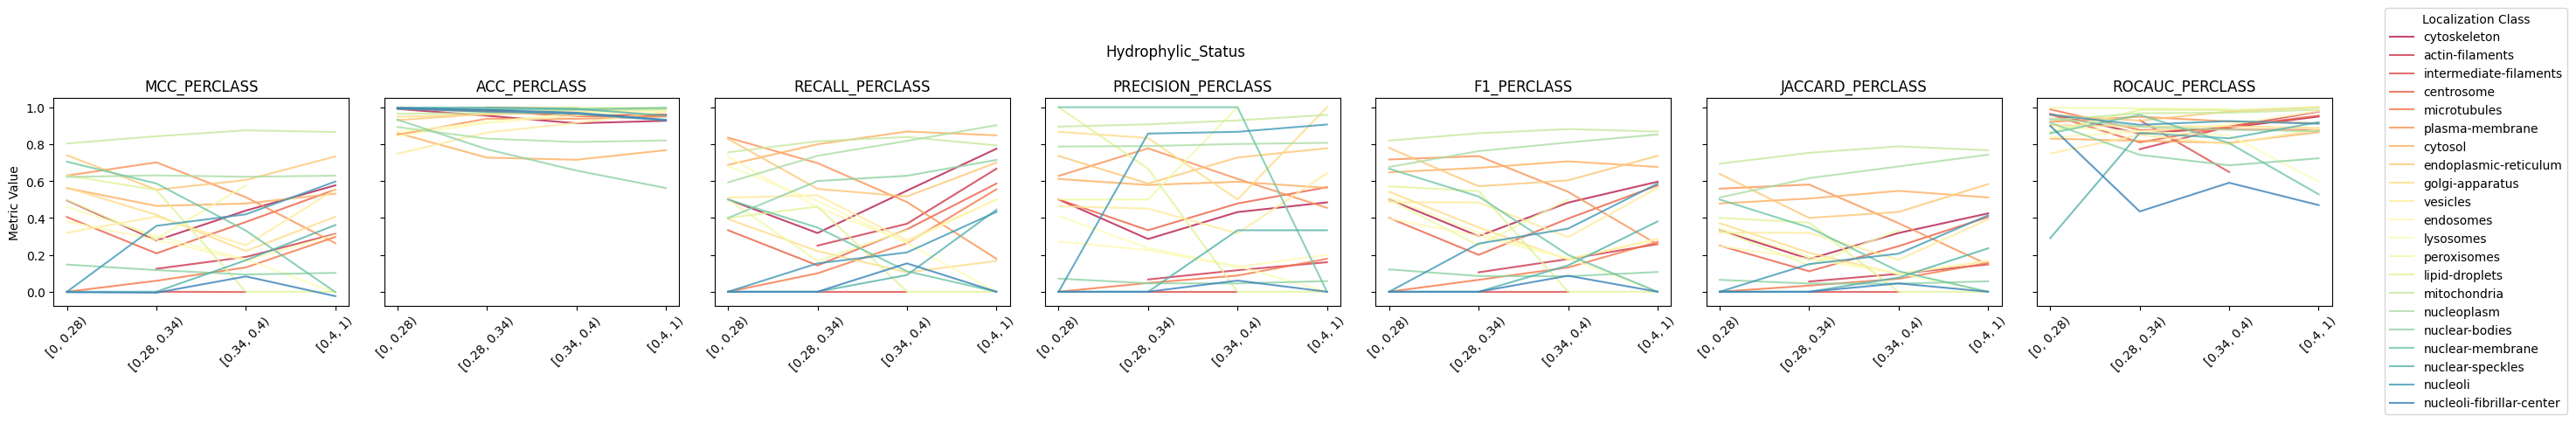

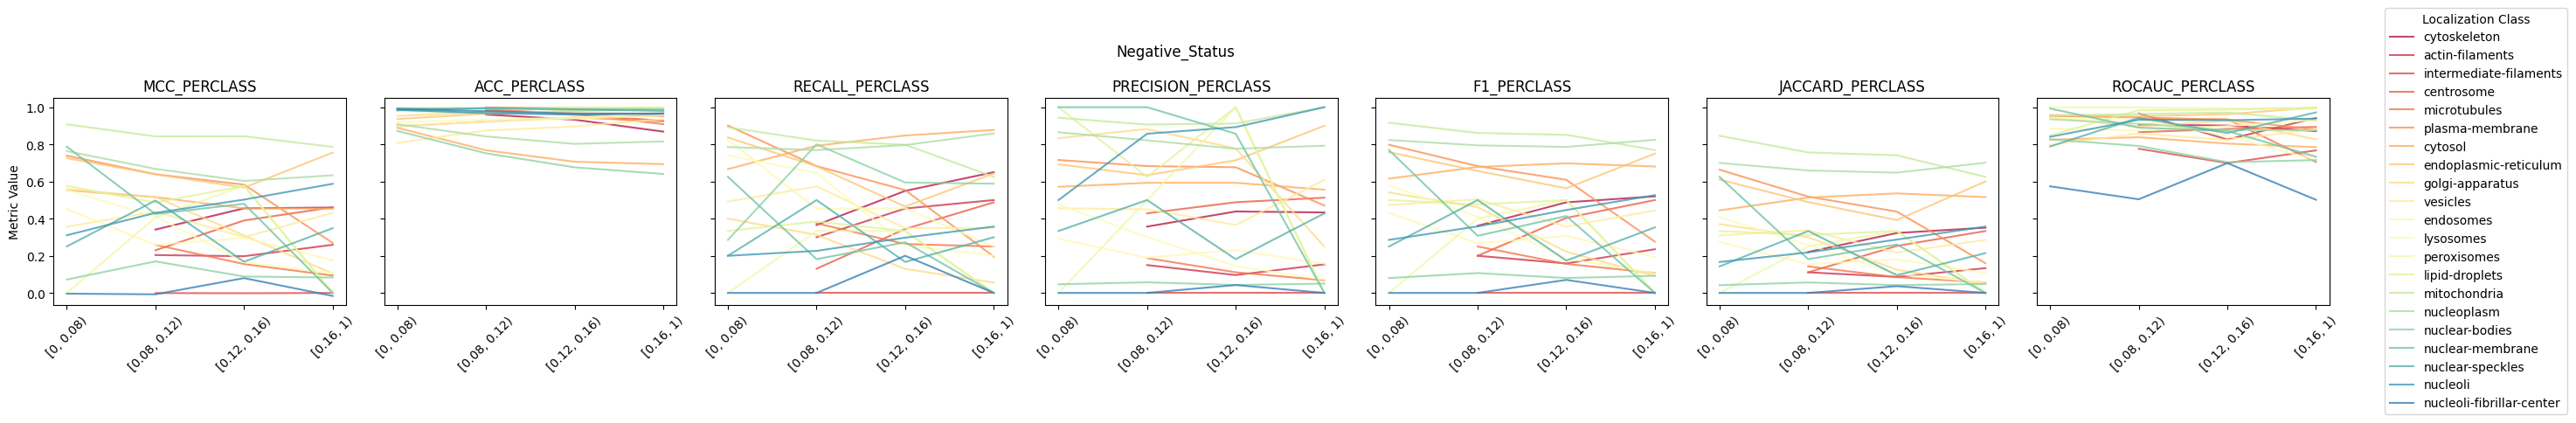

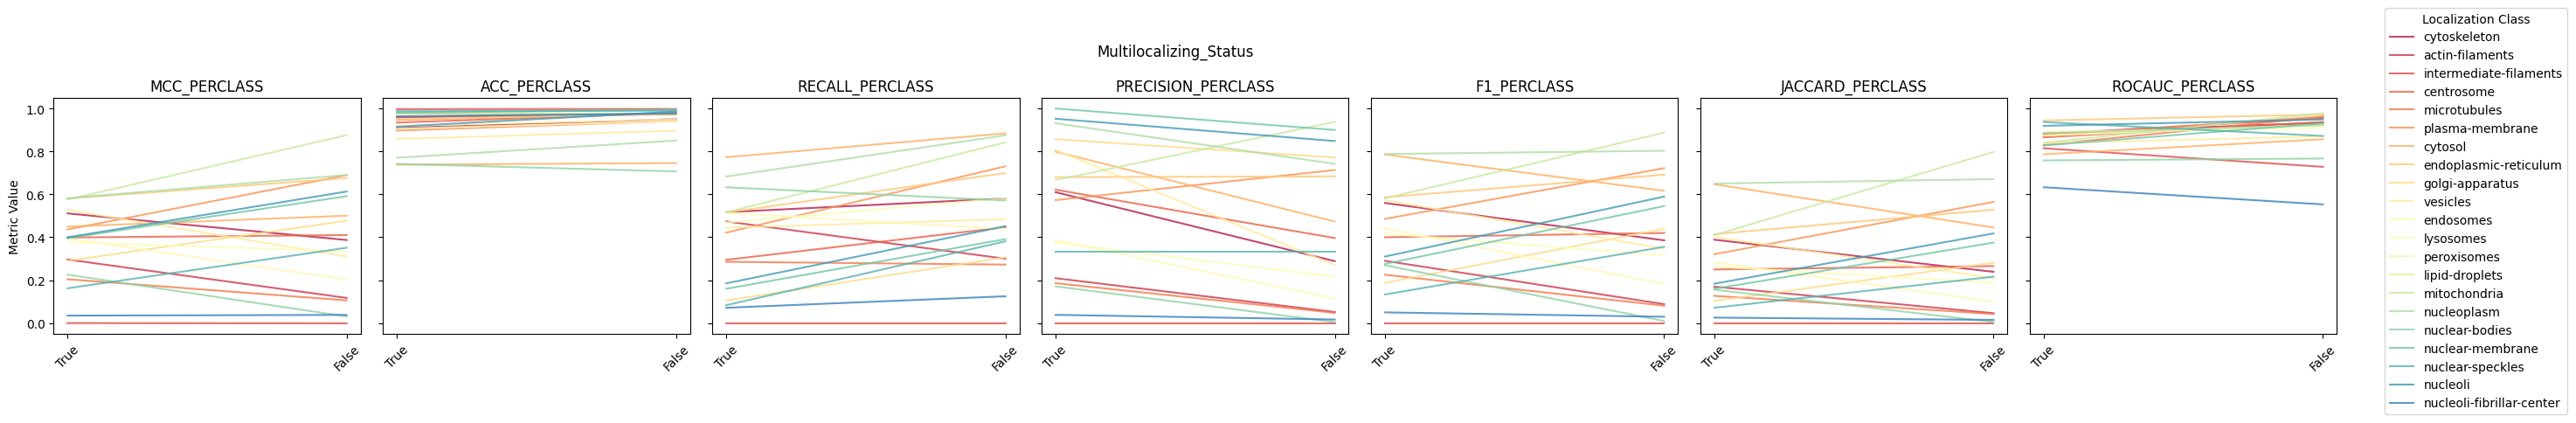

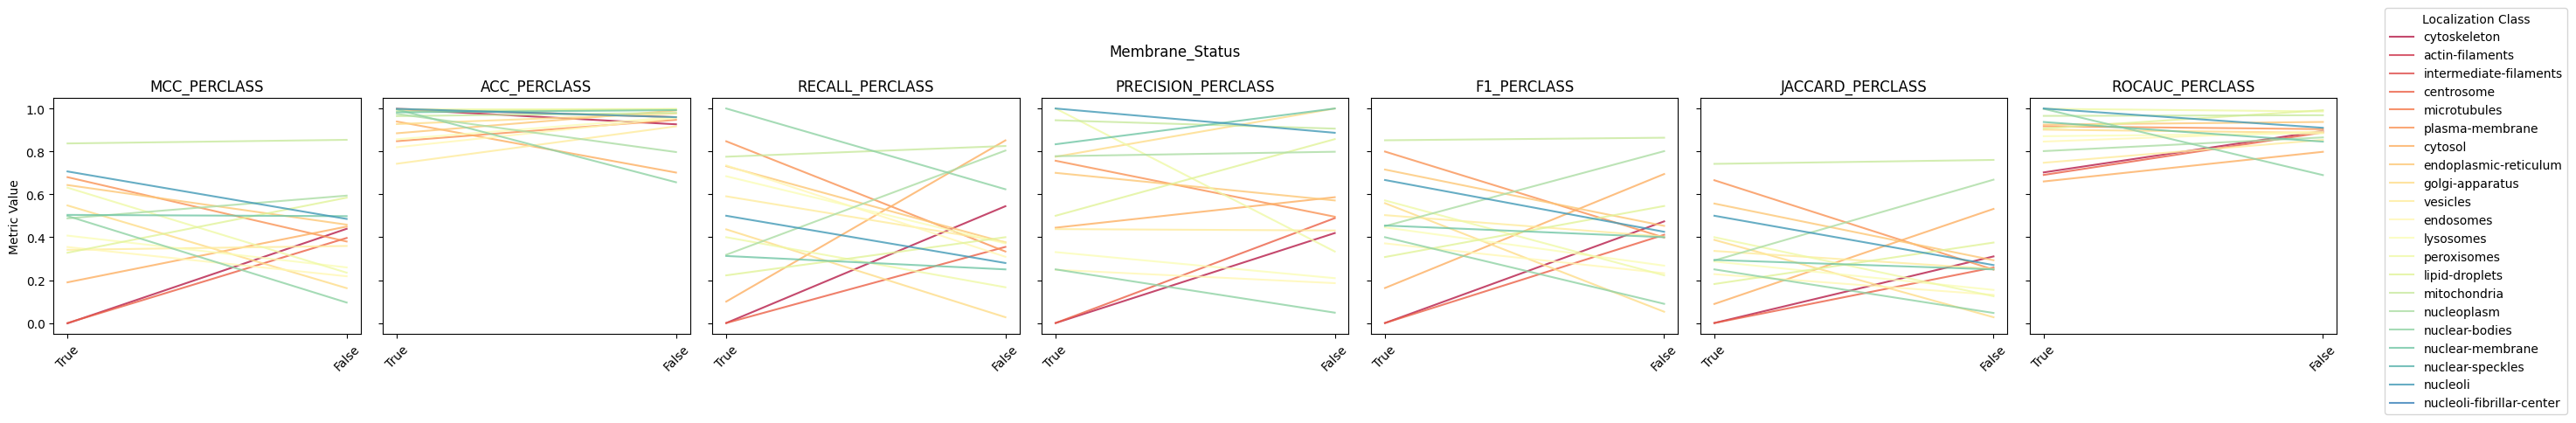

In [21]:
perclass_metrics = ['mcc_perclass', 'acc_perclass', 'recall_perclass', 'precision_perclass', 'f1_perclass', 'jaccard_perclass', 'rocauc_perclass']

for prop in binned_metrics_df['property'].unique():
    prop_df = binned_metrics_df[binned_metrics_df['property'] == prop]
    fig, axes = plt.subplots(1, len(perclass_metrics), figsize=(27, 4), sharex=False, sharey=True)

    class_order = [
                    "cytoskeleton",
                    "actin-filaments",
                    "intermediate-filaments",
                    "centrosome",
                    "microtubules",
                    "plasma-membrane",
                    "cytosol",
                    "endoplasmic-reticulum",
                    "golgi-apparatus",
                    "vesicles",
                    "endosomes",
                    "lysosomes",
                    "peroxisomes",
                    "lipid-droplets",
                    "mitochondria",
                    "nucleoplasm",
                    "nuclear-bodies",
                    "nuclear-membrane",
                    "nuclear-speckles",
                    "nucleoli",
                    "nucleoli-fibrillar-center"
                ]
    
    colors = sns.color_palette("Spectral", n_colors=22)
    class_color_map = dict(zip(class_order, colors))

    bin_order = ordered_categories[prop]

    handles = {}

    for j, metric in enumerate(perclass_metrics):
        for loc_class in class_order:
            xs = []
            ys = []

            for i, bin_label in enumerate(bin_order):
                bin_df = prop_df[prop_df['bin'] == bin_label]
                classes = bin_df.category_perclass.to_list()[0]
                
                if loc_class in classes:
                    idx = classes.index(loc_class)
                    y_val = bin_df[metric].values[0][idx]
                    xs.append(i)
                    ys.append(y_val)
            
            label = loc_class if loc_class not in handles else None
            plot = sns.lineplot(
                x=xs,
                y=ys,
                color=class_color_map[loc_class],
                label=label,
                alpha=0.8,
                ax=axes[j]
            )
            if label:
                handles[loc_class] = plot.lines[-1]
        axes[j].set_xticks(range(len(bin_order)))
        axes[j].set_xticklabels(bin_order, rotation=45)
        axes[j].set_title(metric.upper())
        if j == 0:
            axes[j].set_ylabel("Metric Value")

    for ax in axes:
        if ax.get_legend():
            ax.legend_.remove()

    plt.suptitle(f'{prop}')
    fig.legend(
        handles=[handles[cls] for cls in class_order],
        labels=[cls for cls in class_order],
        title="Localization Class",
        loc='center left',
        bbox_to_anchor=(1.01, 0.5)
    )  
    plt.tight_layout()
    #plt.savefig(f"{FIG_DIR}/stratification_line_{prop}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

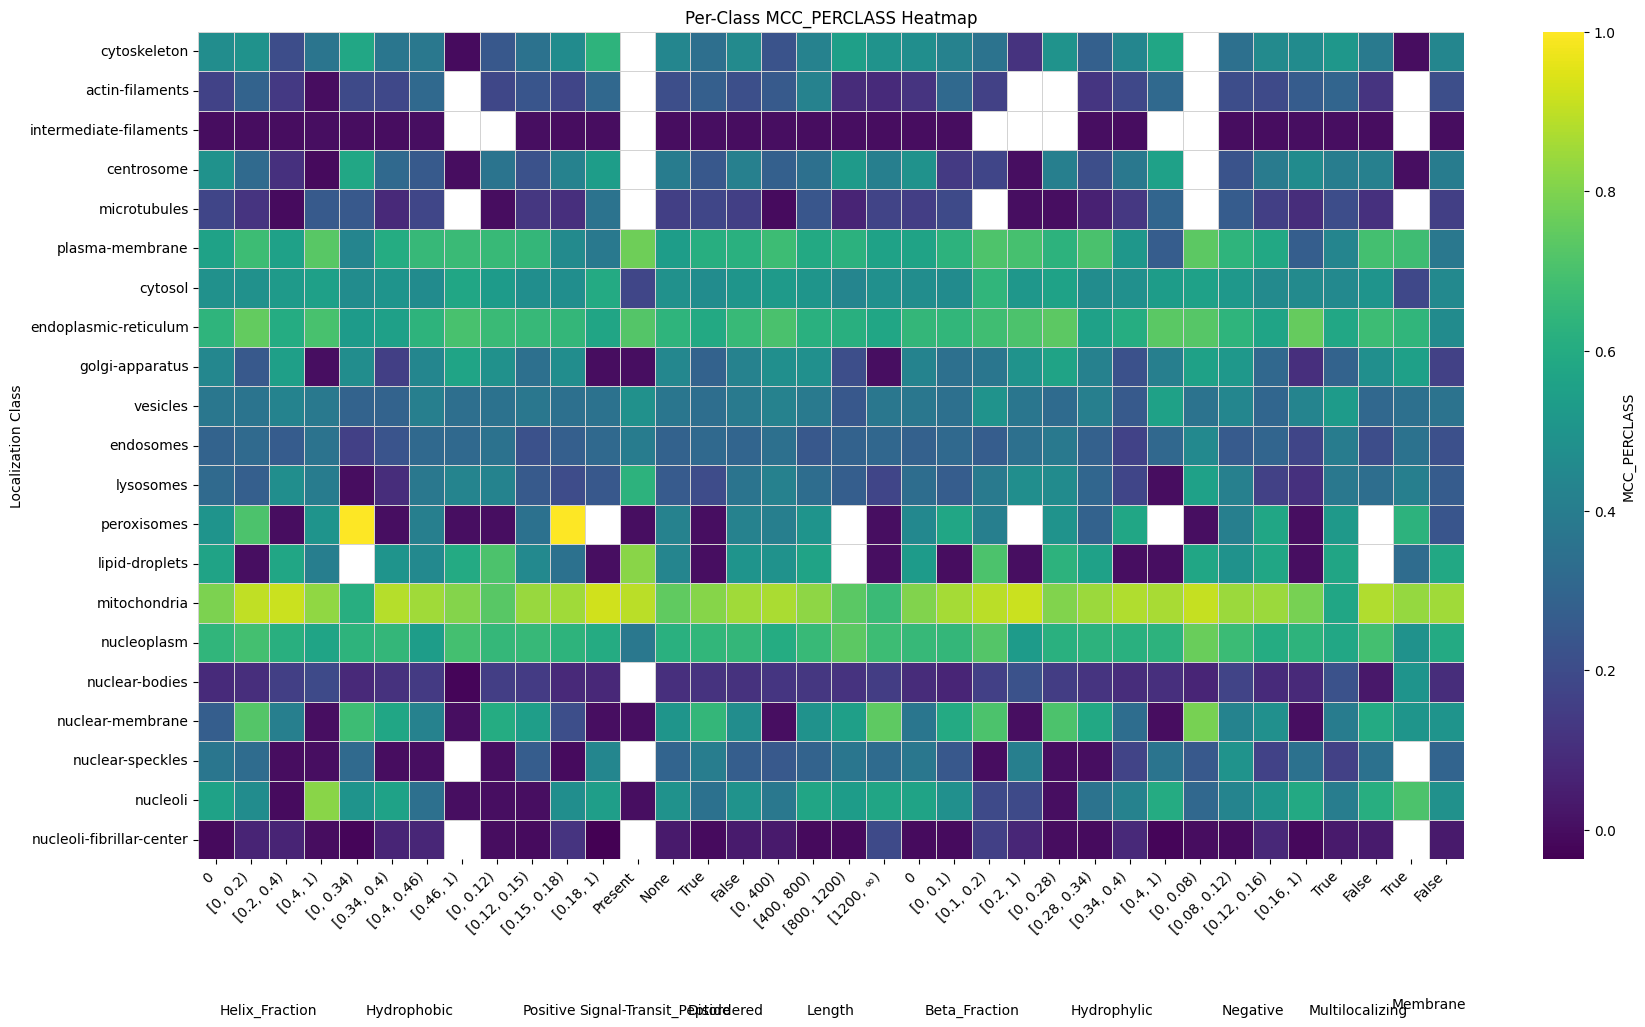

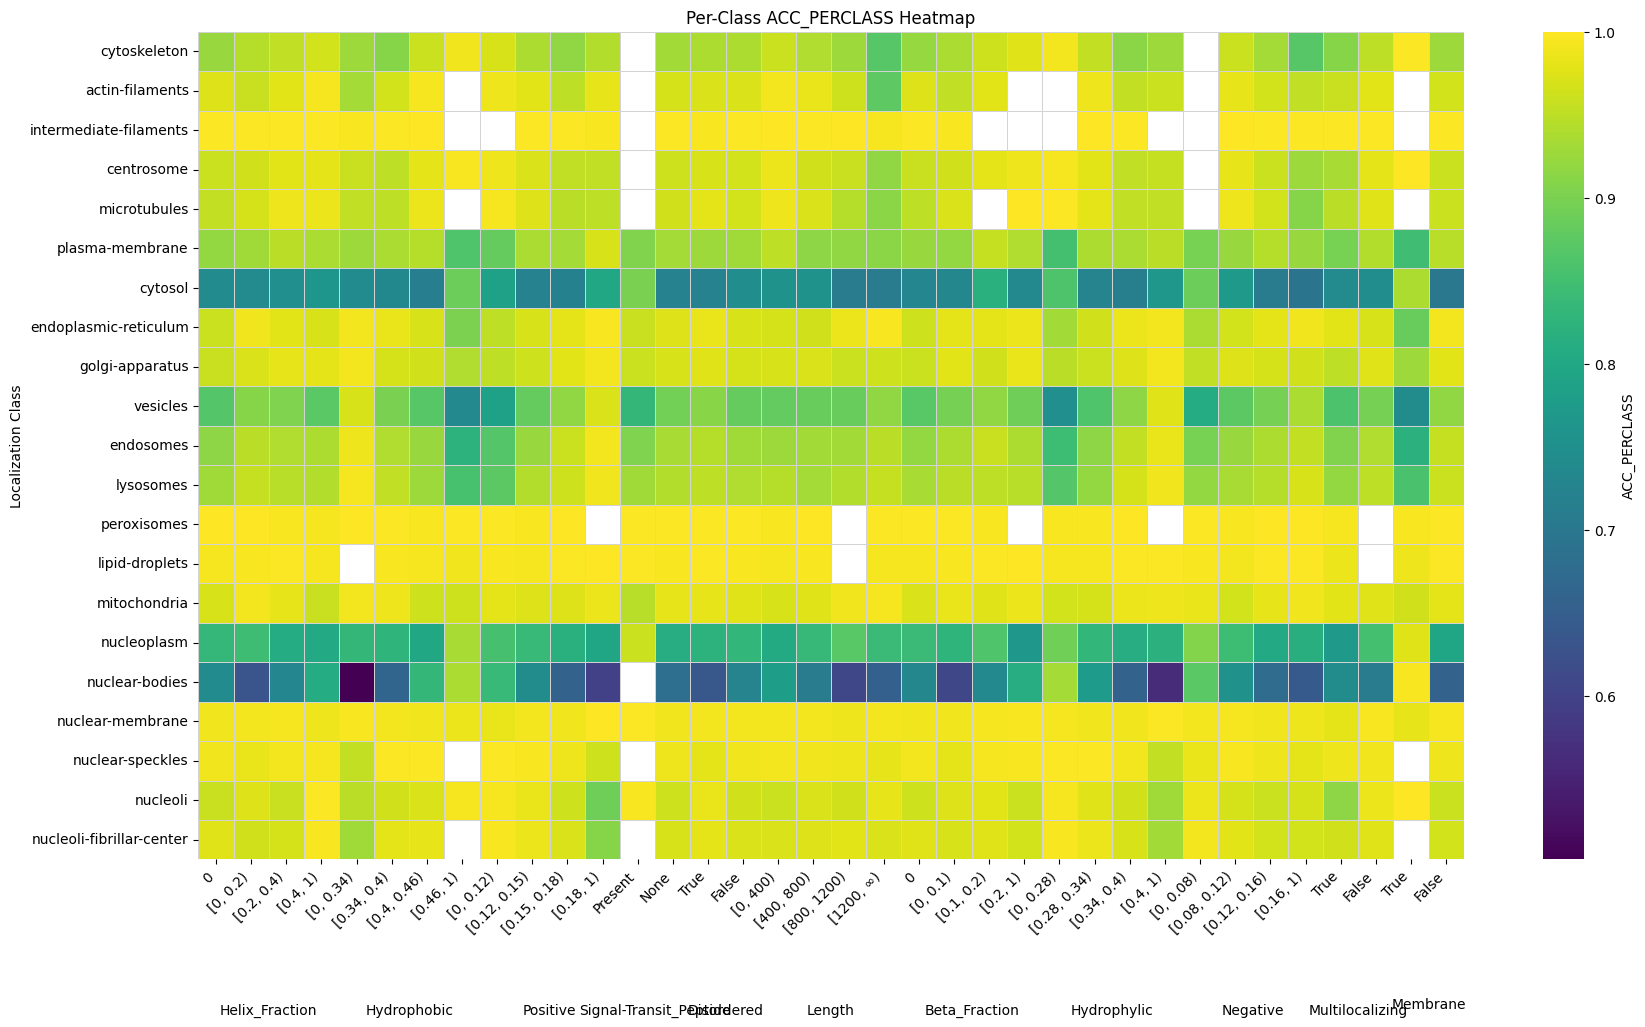

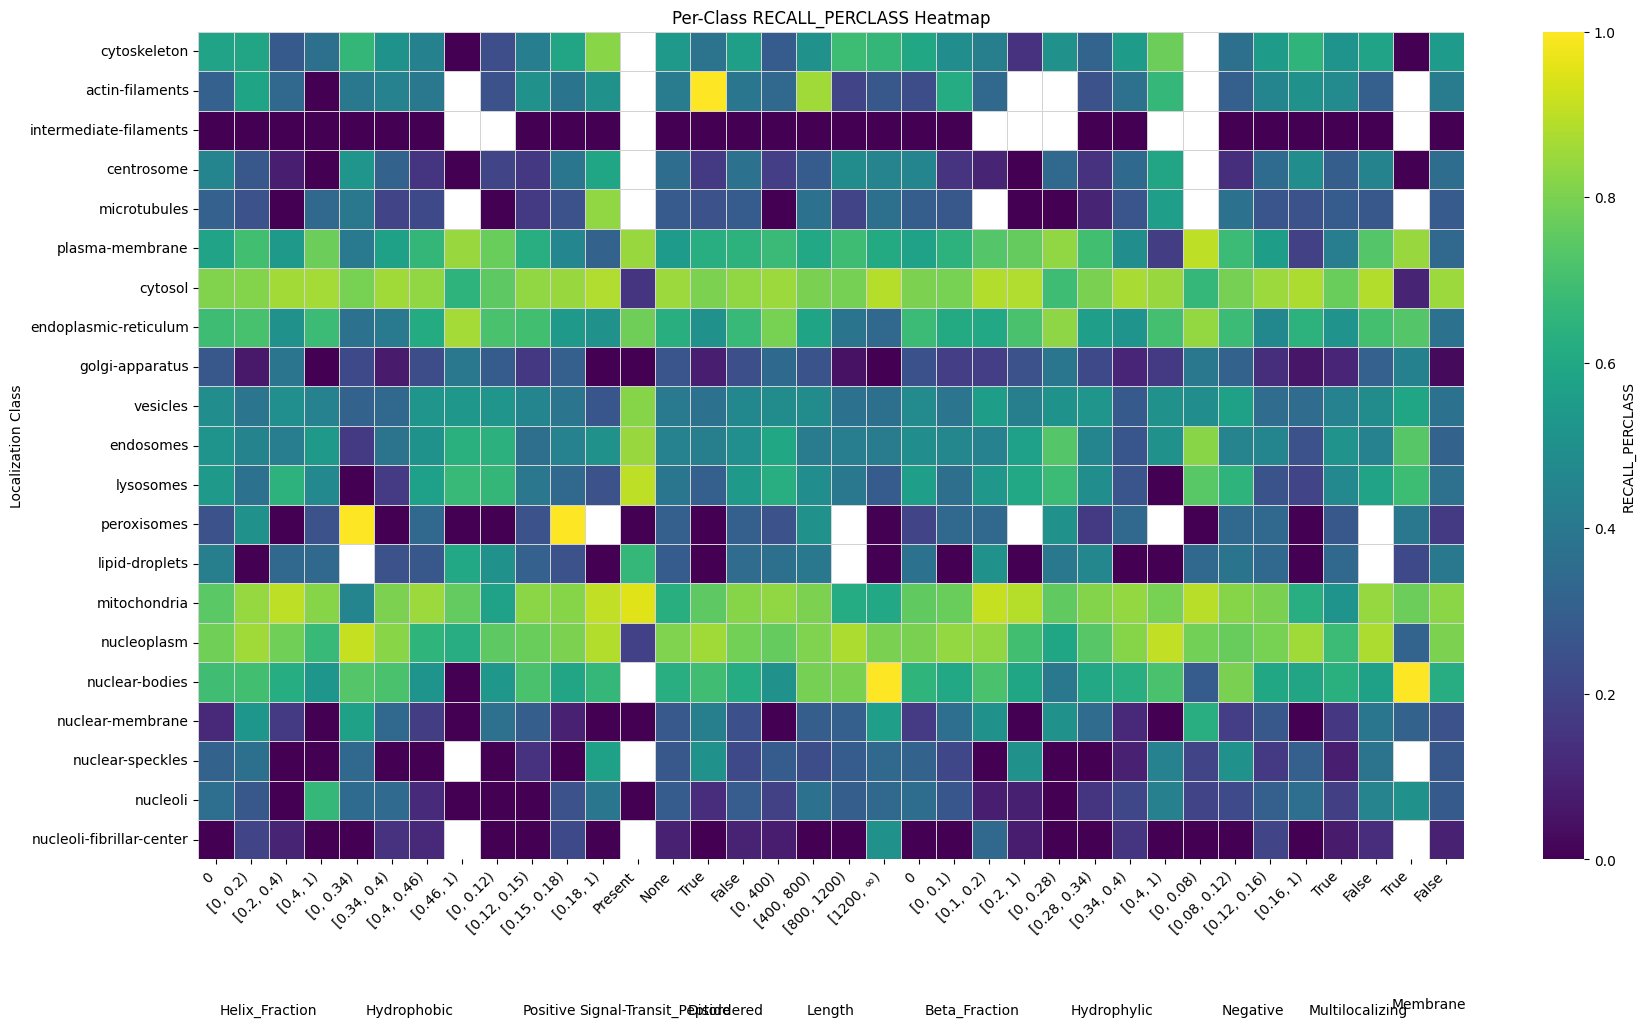

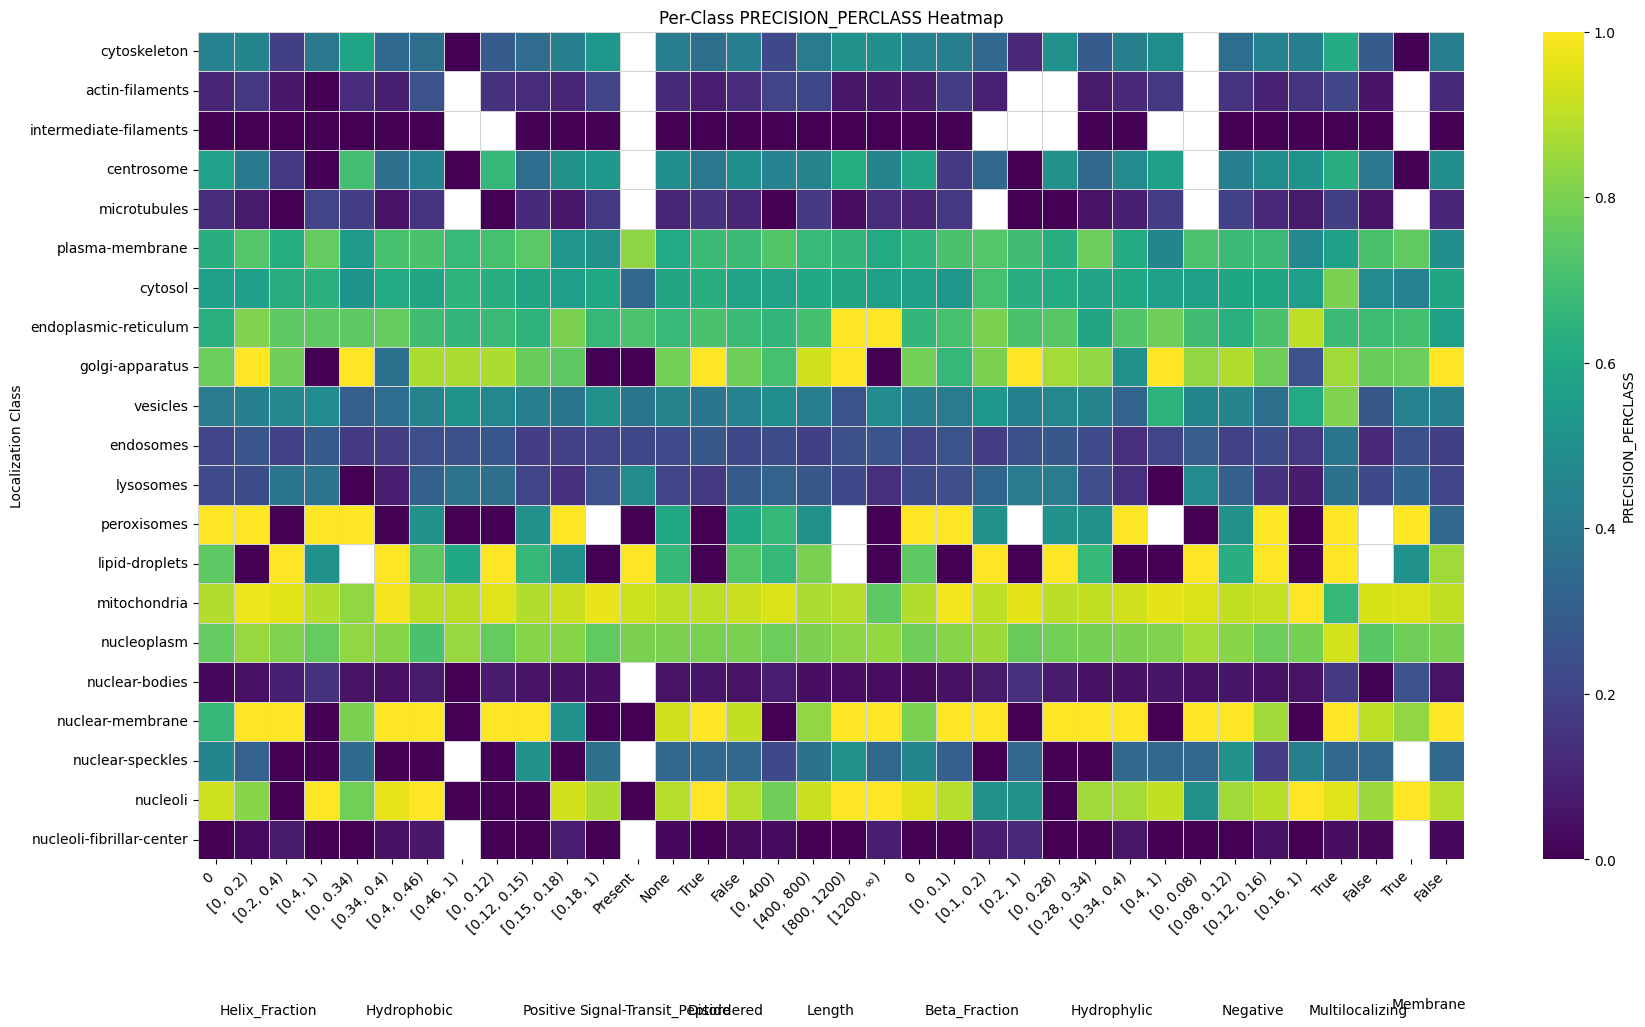

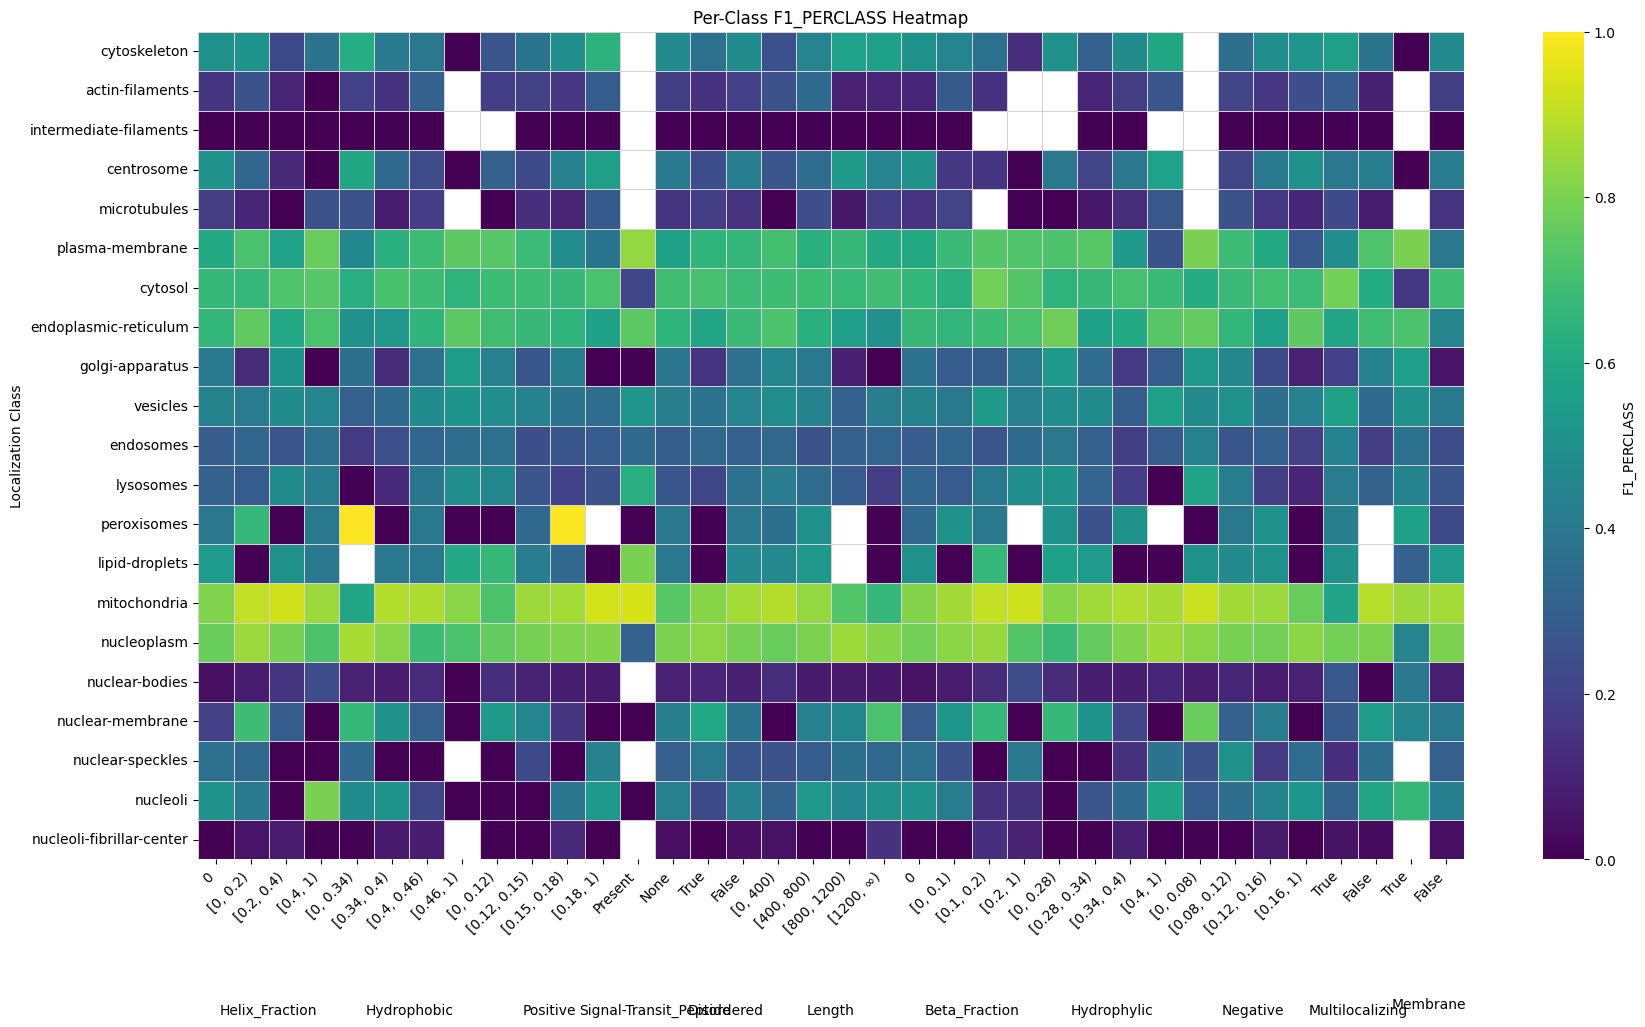

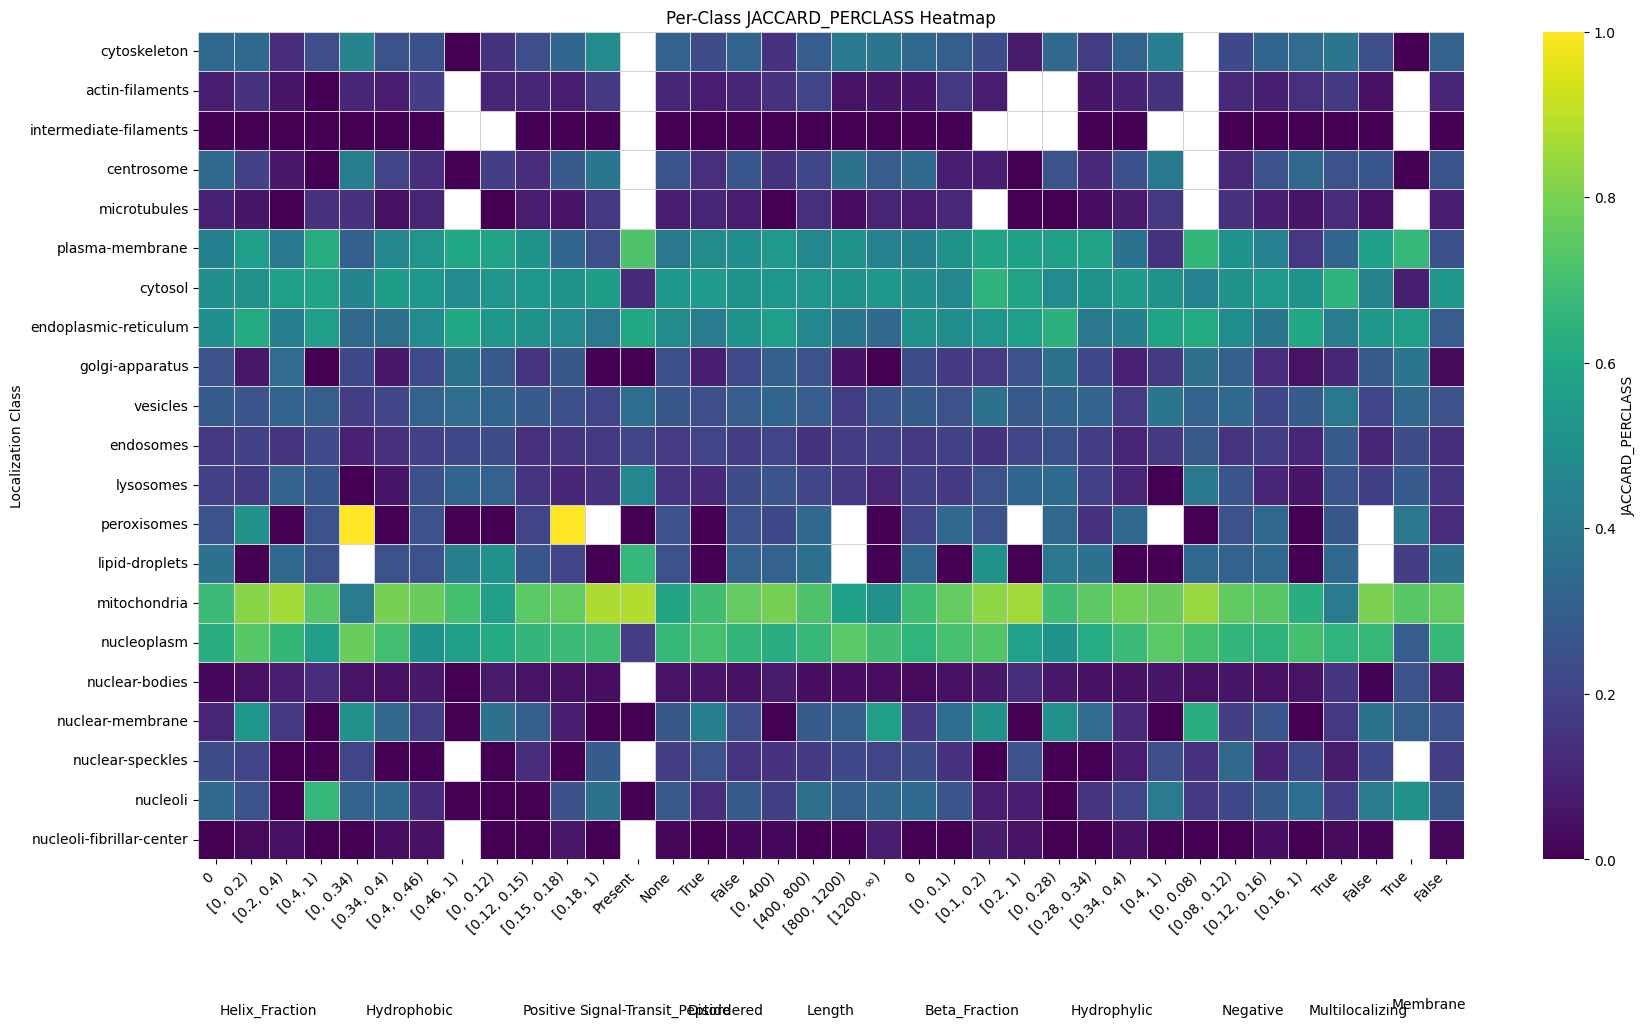

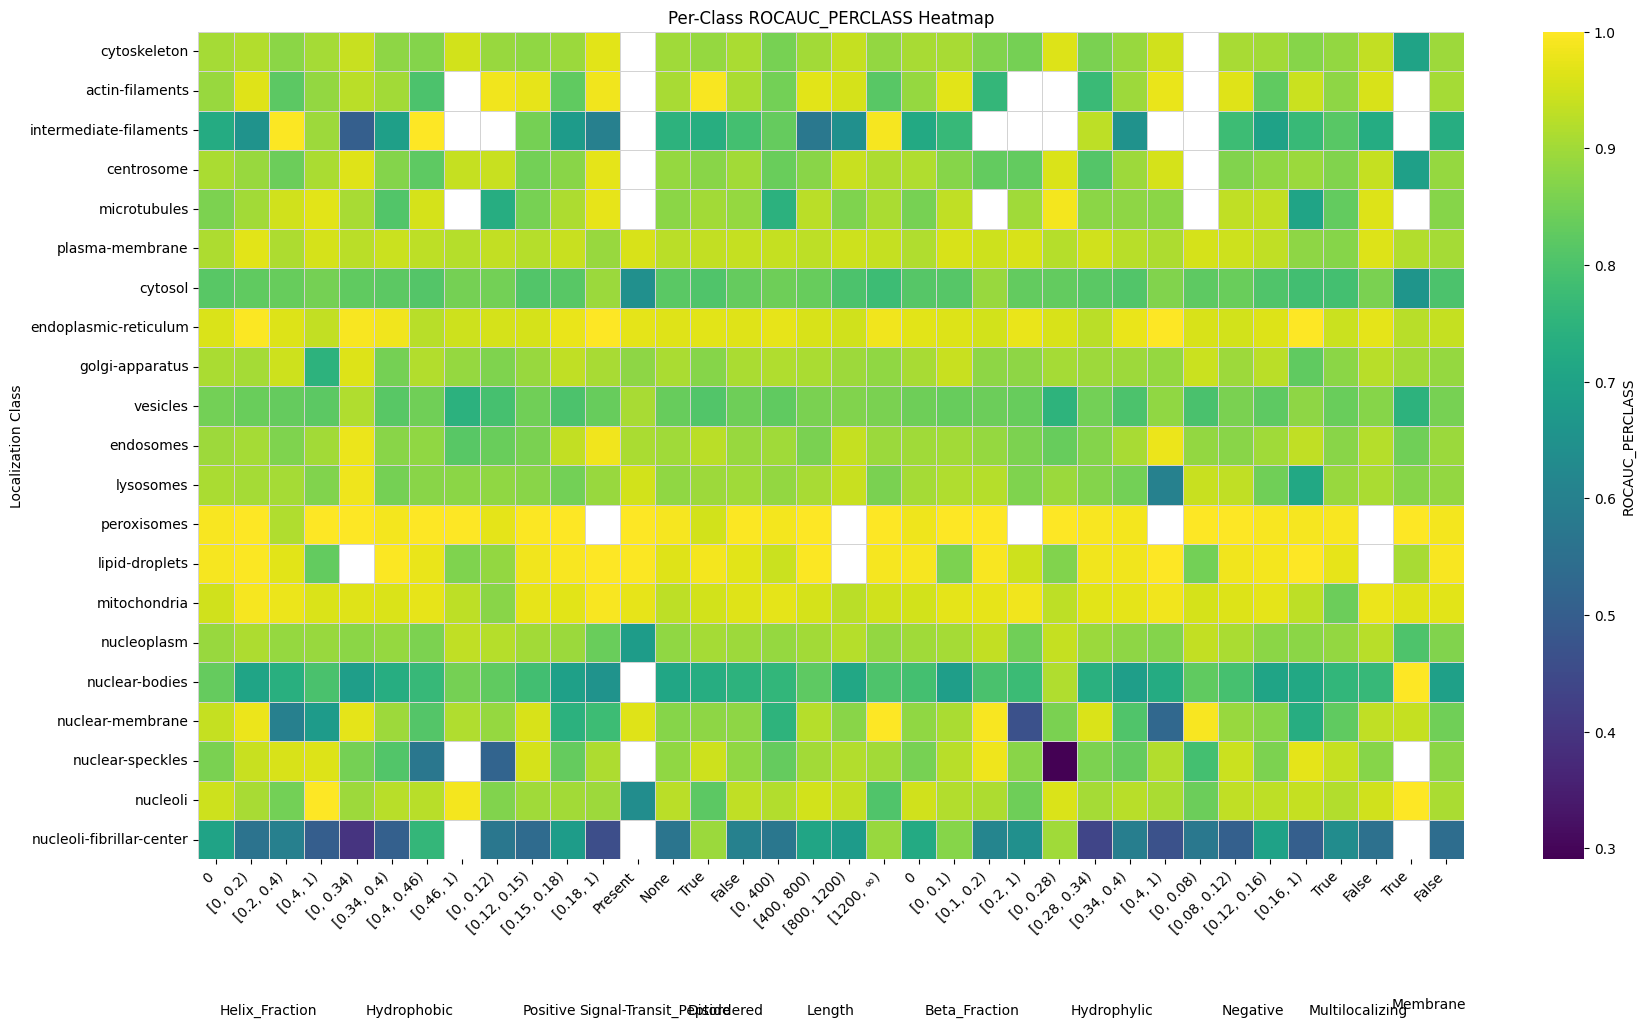

In [22]:
perclass_metrics = ['mcc_perclass', 'acc_perclass', 'recall_perclass', 'precision_perclass', 'f1_perclass', 'jaccard_perclass', 'rocauc_perclass']

class_order = [
                "cytoskeleton",
                "actin-filaments",
                "intermediate-filaments",
                "centrosome",
                "microtubules",
                "plasma-membrane",
                "cytosol",
                "endoplasmic-reticulum",
                "golgi-apparatus",
                "vesicles",
                "endosomes",
                "lysosomes",
                "peroxisomes",
                "lipid-droplets",
                "mitochondria",
                "nucleoplasm",
                "nuclear-bodies",
                "nuclear-membrane",
                "nuclear-speckles",
                "nucleoli",
                "nucleoli-fibrillar-center"
            ]


for metric in perclass_metrics:
    data_collect = []
    bin_labels = []
    bin_to_prop = {}

    for prop in binned_metrics_df['property'].unique():
        prop_df = binned_metrics_df[binned_metrics_df.property == prop]
        bin_order = ordered_categories[prop]

        for b in bin_order:
            row = prop_df[prop_df.bin == b]
            if row.empty:
                continue
            values = row[metric].values[0]
            locs = row['category_perclass'].values[0]

            metric_vals = [values[locs.index(loc)] if loc in locs else np.nan for loc in class_order]
            data_collect.append(metric_vals)
            bin_labels.append(b)
            bin_to_prop[len(bin_labels) - 1] = prop  # map column index to property

    df = pd.DataFrame(np.array(data_collect).T, index=class_order, columns=bin_labels)

    fig, ax = plt.subplots(figsize=(len(bin_labels) * 0.5, 10))
    sns.heatmap(df, cmap="viridis", cbar_kws={'label': metric.upper()}, 
                linewidths=0.5, linecolor='lightgray', ax=ax)

    ax.set_title(f'Per-Class {metric.upper()} Heatmap')
    ax.set_ylabel("Localization Class")

    ax.set_xticks(np.arange(len(bin_labels)) + 0.5)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')

    current_prop = None
    group_start = None
    for i, b in enumerate(bin_labels):
        prop = bin_to_prop[i]
        if prop != current_prop:
            if current_prop is not None:
                midpoint = (group_start + i - 1) / 2
                ax.text(midpoint + 0.5, 25, current_prop.split("_Status")[0],
                        ha='center', va='bottom', fontsize=10)
            current_prop = prop
            group_start = i

    if current_prop is not None:
        midpoint = (group_start + len(bin_labels) - 1) / 2
        ax.text(midpoint + 0.5, 24.5, current_prop.split("_Status")[0],  # <-- adjusted Y
                ha='center', va='top', fontsize=10)

    plt.subplots_adjust(bottom=0.25)
    plt.tight_layout()
    #plt.savefig(f"{FIG_DIR}/stratification_heatmap_{metric}.pdf", bbox_inches='tight', dpi=300)
    plt.show()